In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text
from numpy import pi, e
from numpy.linalg import inv, det
from numpy.linalg import norm as LA_norm
from numpy.random import random
from scipy.stats import norm
from sklearn.datasets import make_spd_matrix
from termcolor import colored
import itertools
from itertools import combinations, product

In [2]:
def create_matrix(m, n):
    return np.random.rand(m, n)

def initial_inputs(flag):
    if flag == 0:
        # Create initial encoder inputs (B, Sigma_W)
        B = create_matrix(m, n)
        Sigma_W = make_spd_matrix(m)
        return np.concatenate(([flag], B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        # Create initial decoder inputs (A, Sigma_Z)
        A = create_matrix(n, m)
        Sigma_Z = np.diag(random(n))
        return np.concatenate(([flag], A.reshape((n*m)), Sigma_Z.reshape((n*n))))

def is_close_to_zero(arr, etol):
    return np.allclose(arr, 0, atol=etol)

def is_singular(matrix):
    is_singular = np.linalg.matrix_rank(matrix) < min(matrix.shape)
    if is_singular:
        print(colored('The matrix is singular.', 'red', attrs=['bold']))
    else:
        print(colored('The matrix is not singular.', 'red', attrs=['bold']))

def is_positive_definite(matrix):
    if np.all(np.linalg.eigvals(matrix) > 0):
        print(colored('The matrix is positive definite.', 'red', attrs=['bold']))
    else:
        print(colored('The matrix is not positive definite.', 'red', attrs=['bold']))

def matrix_B(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    B = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A) @ A.T @ inv_Sigma_Z_hat
    return B

def covariance_matrix_W(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    Sigma_W = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A)
    return Sigma_W

def matrix_A(B, Sigma_W):
    A = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B) @ B.T @ inv(Sigma_W)
    return A

def covariance_matrix_Z(B, Sigma_W):
    Sigma_Z = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B)
    diagonalized_Sigma_Z = np.diag(Sigma_Z.diagonal())
    return diagonalized_Sigma_Z

def covariance_matrix_XV(B):
    cov_XV = np.block([[np.identity(m), B @ eigenvectors @ Sigma_V],
                       [(B @ eigenvectors @ Sigma_V).T, Sigma_V]])
    print(colored('\nCovariance matrix of joint distribution (X,V):', 'blue', attrs=['bold']))
    print(np.round(cov_XV, 4))
    return cov_XV

def encoder_mi(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(Sigma_W))

def decoder_mi(A, Sigma_Z):
    return 0.5 * np.log(det(A @ A.T + Sigma_Z) / det(Sigma_Z))

def mi_VX(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(sigma_squared * B @ B.T + Sigma_W))

def reconstruction_error(recon, orig):
    norm_diff = LA_norm(orig - recon, 2)
    orig_norm = LA_norm(orig, 2)
    recon_err = norm_diff / orig_norm
    return recon_err

def objective_function(A, B, Sigma_Z, Sigma_W):
    Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
    
    regularizer = 0.5 * (np.trace(Sigma_X) - np.log(det(Sigma_W)) - m)
    reconstruction = 0.5 * (np.trace(Sigma_X) + \
                            np.trace(A.T @ inv(Sigma_Z) @ Sigma_Y @ B.T) + \
                            np.trace(inv(Sigma_Z) @ A @ B @ Sigma_Y) - \
                            np.trace(inv(Sigma_Z) @ Sigma_Y) - \
                            np.trace((np.identity(m) + A.T @ inv(Sigma_Z) @ A) @ Sigma_X) - \
                            n * np.log(2 * pi) - np.log(det(Sigma_Z)))
    lambda_term = lamda * np.trace((np.identity(n) - A @ B) @ Sigma_Y @ ((np.identity(n) - A @ B).T) + A @ Sigma_W @ A.T)
    
    return regularizer - gamma * reconstruction + lambda_term

In [3]:
def plot_cost_function(cf_arr):
    """
    Plot values of objective function against iterations t
    """
    plt.plot(range(1, len(cf_arr) + 1), cf_arr)
    plt.xlabel('t')
    plt.ylabel('Cost Function', fontsize=10)
    plt.show()

def plot_encoder_mi(en_mi_arr):
    """
    Plot mutual information of encoder against iterations t
    """
    plt.plot(range(1, len(en_mi_arr) + 1), en_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Encoder', fontsize=10)
    plt.show()

def plot_decoder_mi(de_mi_arr):
    """
    Plot mutual information of decoder against iterations t
    """
    plt.plot(range(1, len(de_mi_arr) + 1), de_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Decoder', fontsize=10)
    plt.show()

In [4]:
def print_optimal_solution(sol, m):
    A_arr = sol[:n*m] 
    B_arr = sol[n*m:2*n*m]
    Sigma_Z_arr = sol[2*n*m:2*n*m+n*n]
    Sigma_Z = Sigma_Z_arr.reshape((n, n))
    Sigma_W_arr = sol[2*n*m+n*n:2*n*m+n*n+m*m]
    Sigma_W = Sigma_W_arr.reshape((m, m))
    cost_function = sol[2*n*m+n*n+m*m:2*n*m+n*n+m*m+1][0]
    en_mi = sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0]
    de_mi = sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0]
    recon_err = sol[-1]
    len_cf_mi_arr = sol[2*n*m+n*n+m*m+3:2*n*m+n*n+m*m+6]
    Sigma_X = sol[2*n*m+n*n+m*m+6:2*n*m+n*n+2*m*m+6].reshape((m, m))
    Sigma_Y_hat = sol[2*n*m+n*n+2*m*m+6:2*n*m+2*n*n+2*m*m+6].reshape((n, n))
    
    print(colored('Optimal solution:', attrs=['bold']))
    
    if m > 1:
        print('Matrix A:\n{}'.format(np.round(A_arr.reshape((n, m)), 4)))
        print('\nMatrix B:\n{}'.format(np.round(B_arr.reshape((m, n)), 4)))
        print('\nCovariance matrix of Z:\n{}'.format(np.round(Sigma_Z, 4)))
        print('\nCovariance matrix of W:\n{}'.format(np.round(Sigma_W, 4)))
        print('\nMinimum value of the cost function:\n{}'.format(round(cost_function, 4)))
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 8)))
        print('\nMutual information of the decoder:\n{}'.format(round(de_mi, 8)))
        print('\nValue of Sigma_X:\n{}'.format(np.round(Sigma_X, 4)))
        print('\nValue of Sigma_Y_hat:\n{}'.format(np.round(Sigma_Y_hat, 4)))
        print('\nReconstruction error:\n{}'.format(round(recon_err, 8)))
    else:
        print('Vector a:\n{}'.format(np.round(A_arr.reshape((n, m)), 4)))
        print('\nVector b:\n{}'.format(np.round(B_arr.reshape((m, n)), 4)[0]))
        print('\nCovariance matrix of Z:\n{}'.format(np.round(Sigma_Z, 4)))
        print('\nVariance of W:\n{}'.format(np.round(Sigma_W, 4)[0][0]))
        print('\nMinimum value of the cost function:\n{}'.format(round(cost_function, 4)))
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 8)))
        print('\nMutual information of the decoder:\n{}'.format(round(de_mi, 8)))
        print('\nValue of Sigma_X:\n{}'.format(np.round(Sigma_X, 4)))
        print('\nValue of Sigma_Y_hat:\n{}'.format(np.round(Sigma_Y_hat, 4)))        
        print('\nReconstruction error:\n{}'.format(round(recon_err, 8)))
        
    return len_cf_mi_arr

def print_comprehensive_results(gamma, lamda, flag, m, n, is_arr):
    if flag == 0:
        # Generate random initial encoder inputs (B, Sigma_W)
        B, Sigma_W = initial_inputs(flag)[1:1+m*n].reshape((m, n)), initial_inputs(flag)[1+m*n:1+m*n+m*m].reshape((m, m))
    else:
        # Generate random initial decoder inputs (A, Sigma_Z)
        A, Sigma_Z = initial_inputs(flag)[1:1+n*m].reshape((n, m)), initial_inputs(flag)[1+n*m:1+n*m+n*n].reshape((n, n))
    
    # Print given inputs
    if is_arr == 0:
        if m > 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial matrix B:')
            print(np.round(B.reshape((m, n)), 4))
            print('\nInitial covariance matrix of W:')
            print(np.round(Sigma_W, 4))
        elif m == 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial vector b:')
            print(np.round(B.reshape((m, n)), 4)[0])
            print('\nInitial variance of W:')
            print(np.round(Sigma_W, 4)[0][0])
        elif m > 1 and flag == 1:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial matrix A:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))
        else:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial vector a:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))    
    
        # Print results
        if flag == 0:
            # Compute optimal solution given encoder inputs
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
    
            # Extract length of arrays for cost function and mutual information of encoder and decoder
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            # Plot values of cost function and mutual information against iterations
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)  
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
        
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)
    else:
        if flag == 0:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 8)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 8)
            recon_err = round(opt_sol[-1], 8)
            
            return [recon_err, en_mi, de_mi, opt_sol]
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 8)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 8)
            recon_err = round(opt_sol[-1], 8)
            
            return [recon_err, en_mi, de_mi, opt_sol]

In [5]:
"""

*****************************************************************
**                          ALGORITHM                          **
*****************************************************************
   
Inputs:
- MAX_ITERS: Maximum number of iterations
- n, m: Dimensions of the matrix
- TOL_ERR: Tolerable error
- Sigma_Y: A random nxn positive definite matrix

Algorithm:
1. Initialize flag
    a. If we start with the encoder, set flag = 0.
    b. Otherwise, set flag = 1.
    
2. Generate initial inputs for the iteration step
    a. If flag = 0, then do:
        i. create random initial encoder inputs, including 
            - a random mxn matrix B
            - a random mxm positive definite covariance matrix Sigma_W
        ii. set flag = 1.
    b. If flag = 1, then do:
        i. create random initial decoder inputs, including 
            - a random nxm matrix A
            - a random nxn positive definite covariance matrix Sigma_Z
        ii. set flag = 0.
        
3. Set iteration counter i = 0. 

4. Iterative step
    a. If flag = 0, given the decoder inputs (A, Sigma_Z) at iteration i,
        i. compute the corresponding encoder inputs at iteration i+1:
            B = matrix_B(A, Sigma_Z)
            Sigma_W = covariance_matrix_W(A, Sigma_Z)
        ii. set flag = 1.
        iii. compute the resulting gamma-VAE cost function and mutual information of the encoder.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
    b. If flag = 1, given the encoder inputs (B, Sigma_W) at iteration i,
        i. compute the corresponding decoder inputs at iteration i:
            A = matrix_A(B, Sigma_W)
            Sigma_Z = covariance_matrix_Z(B, Sigma_W, is_diagonal)
        ii. set flag = 0.
        iii. compute the resulting gamma-VAE cost function, mutual information of the decoder, and reconstruction error.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
            
5. Increment iteration counter i <- i + 1.

6. If the iteration counter i < MAX_ITERS, then move back to step 4.
    Otherwise, move to step 7.
    
7. Compute the values of Sigma_X and Sigma_Y_hat.
        
8. Display results
    a. display the optimal solution (A, B, Sigma_Z, Sigma_W).
    b. display the corresponding minimum value of gamma-VAE cost function.
    c. display the resulting mutual information of both encoder and decoder.
    d. display the values of Sigma_X and Sigma_Y_hat.
    e. display the value of reconstruction error.
    f. move to step 9.
    
9. Stop.

"""

def rate_distortion(inputs, is_arr):
    flag = inputs[0]
    if flag == 0:
        B = inputs[1:1+m*n].reshape((m, n))
        Sigma_W = inputs[1+m*n:1+m*n+m*m].reshape((m, m))
        flag = 1
        # Array of current encoder inputs (B_t, Sigma_W_t)
        current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        A = inputs[1:1+n*m].reshape((n, m))
        Sigma_Z = inputs[1+n*m:1+n*m+n*n].reshape((n, n))
        flag = 0
        # Array of current decoder inputs (A_t, Sigma_Z_t)
        current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
    
    # Cost function and mutual information arrays
    cf_arr = []
    en_mi_arr = []
    de_mi_arr = [] 

    # Iteration step
    try:
        for i in range(0, MAX_ITERS):
            if  flag == 0:
                B = matrix_B(A, Sigma_Z)
                Sigma_W = covariance_matrix_W(A, Sigma_Z)
                flag = 1
                
                # Check if the value of the cost function is not a number
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_en_mi = encoder_mi(B, Sigma_W)
                en_mi_arr = np.concatenate((en_mi_arr, [current_en_mi]))
                
                # For the first iteration, update the current encoder inputs and value of the cost function
                if i == 0:
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. B and itself in the previous iteration
                #    ii. Sigma_W and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current encoder inputs and value of the cost function
                else:
                    B_diff = B - current_encoder_inputs[:m*n].reshape((m, n))
                    B_norm_diff = LA_norm(B_diff, 'fro')
                    Sigma_W_diff = Sigma_W - current_encoder_inputs[m*n:m*n+m*m].reshape((m, m))
                    Sigma_W_norm_diff = LA_norm(Sigma_W_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    # Check for convergence
                    if B_norm_diff <= TOL_ERR and Sigma_W_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break
            else:
                A = matrix_A(B, Sigma_W)
                Sigma_Z = covariance_matrix_Z(B, Sigma_W)
                flag = 0
                
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_de_mi = decoder_mi(A, Sigma_Z)
                de_mi_arr = np.concatenate((de_mi_arr, [current_de_mi]))
                
                Sigma_Y_hat = A @ A.T + Sigma_Z
                recon_err = reconstruction_error(Sigma_Y_hat, Sigma_Y)
                
                # For the first iteration, update the current decoder inputs and value of the cost function
                if i == 0:
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. A and itself in the previous iteration
                #    ii. Sigma_Z and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current dencoder inputs and value of the cost function                
                else:
                    A_diff = A - current_decoder_inputs[:n*m].reshape((n, m))
                    A_norm_diff = LA_norm(A_diff, 'fro')
                    Sigma_Z_diff = Sigma_Z - current_decoder_inputs[n*m:n*m+n*n].reshape((n, n))
                    Sigma_Z_norm_diff = LA_norm(Sigma_Z_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    # Check for convergence
                    if A_norm_diff <= TOL_ERR and Sigma_Z_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break                       

        # Compute Sigma_X and Sigma_Y_hat  
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi],
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
          
        if is_arr == 0 and i == MAX_ITERS - 1 and recon_err > MAX_RECON_ERR:
            print(colored('\nMax iterations was reached!', 'red', attrs=['bold']))
            print('There is NO solutions that has reconstruction error statisfying the tolerance error = {}.\n'.format(MAX_RECON_ERR))
            
        return sol
    
    except Exception as e:
        if is_arr == 0:
            print(colored('\nThe algorithm fails to converge after {} iterations due to {}.\n'.format(i+1, e), 'red', attrs=['bold']))
         
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi], 
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
        return sol

In [6]:
def generate_Sigma_V(case):
    for case_idx in range(num_cases):
        if case_idx == 0:
            # Case 1: Independent of generative parameters
            std_devs = [std_dev_v1, std_dev_v2, std_dev_v3]
            V_1 = [np.random.normal(mean, std_dev, size=num_samples) for std_dev in std_devs]

            # Compute covariance matrix of V 
            Sigma_V_1 = np.round(np.cov(V_1), 4)
        
        elif case_idx == 1:
            # Case 2: Linear dependence of v_1 and v_2, with independence of v_3
            v_1 = np.random.normal(mean, std_dev_v1, size=num_samples)
            v_3 = np.random.normal(mean, std_dev_v3, size=num_samples)
            
            # Calculate v_2 using scaling factor alpha and random noise
            random_noise_z2 = np.random.normal(mean, std_dev_z2, num_samples)
            v_2 = alpha * v_1 + random_noise_z2
            
            # Create generative variable V
            V_2 = np.array([v_1, v_2, v_3])

            # Compute covariance matrix of V 
            Sigma_V_2 = np.round(np.cov(V_2), 4)  
        
        else:
            # Case 3: Linear dependence of v_2 and v_3, with v_1
            v_1 = np.random.normal(mean, std_dev_v1, size=num_samples)
            
            # Calculate additional generative parameters using scaling factors
            random_noise_z2 = np.random.normal(mean, std_dev_z2, num_samples)
            random_noise_z3 = np.random.normal(mean, std_dev_z3, num_samples)
            v_2 = alpha * v_1 + random_noise_z2
            v_3 = beta * v_1 + random_noise_z3

            # Create generative variable V
            V_3 = np.array([v_1, v_2, v_3])

            # Compute covariance matrix of V 
            Sigma_V_3 = np.round(np.cov(V_3), 4)
    
    if case == 0:
        print(colored('Scenario 1:', attrs=['bold','underline']))
        print(f'Given (sigma_v1, sigma_v2, sigma_v3) = {std_dev_v1, std_dev_v2, std_dev_v3}:')
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_1)
        is_singular(Sigma_V_1)
        return Sigma_V_1
    
    elif case == 1:
        print(colored('Scenario 2:', attrs=['bold','underline']))
        print(f'Given (sigma_v1, sigma_v3) = {std_dev_v1, std_dev_v3}, alpha = {alpha}, and sigma_z2 = {std_dev_z2}:')
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_2)
        is_singular(Sigma_V_2) 
        return Sigma_V_2
    
    else:
        print(colored('Scenario 3:', attrs=['bold','underline']))
        print(f'Given sigma_v1 = {std_dev_v1}, (alpha, beta) = {alpha, beta}, and (sigma_z2, sigma_z3) = {std_dev_z2, std_dev_z3}:')
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_3)
        is_singular(Sigma_V_3)  
        return Sigma_V_3

## I. Inputs

In [7]:
"""
Given:
1. Maximum number of iterations: MAX_ITERS = 10,000
2. Dimensions of the matrix: s = 3, n = 4, and m = 3
3. Tolerable error: TOL_ERR = 1e-8
4. Reconstruction error tolerance: MAX_RECON_ERR = 0.05
5. A nxn positive definite matrix Sigma_Y = Gamma * Sigma_V * Gamma_T + Sigma_Z_tilde
6. An array of gamma = [0.98, 1.02] with step size = 0.01
7. An array of lambda = [-0.02, 0.02] with step size = 0.01
"""

# Constants
MAX_ITERS = 10000
s, n, m = 3, 4, 3
TOL_ERR = 1e-8
MAX_RECON_ERR = 0.05

num_cases = 3
num_samples = int(1e7)
alpha = 2
beta = 4
mean = 0
std_dev_v1 = 0.01
std_dev_v2 = 0.02
std_dev_v3 = 0.03
std_dev_z2 = 0.02
std_dev_z3 = 0.03

# Arrays of gamma and lambda
gamma_arr = np.round(np.arange(0.98, 1.02, 0.01), 2)
print(colored('An array of gamma:', 'blue', attrs=['bold']))
print('{}'.format(gamma_arr))

lambda_arr = np.round(np.arange(-0.02, 0.03, 0.01), 2)
print(colored('\nAn array of lambda:', 'blue', attrs=['bold']))
print('{}'.format(lambda_arr))

# Independent eigenvectors
eigenvectors = np.array([[1, 0, 0],
                         [0, 1, 0],
                         [0, 0, 1],
                         [0, 0, 0]])
print(colored('\nIndependent eigenvectors:', 'blue', attrs=['bold']))
print(eigenvectors)

# Covariance of noise Z_tilde
sigma_squared = 0.04**2
Sigma_Z_tilde = sigma_squared * np.identity(n)
print(colored('\nCovariance of noise Z_tilde:', 'blue', attrs=['bold']))
print(np.round(Sigma_Z_tilde, 4))

An array of gamma:
[0.98 0.99 1.   1.01 1.02]

An array of lambda:
[-0.02 -0.01  0.    0.01  0.02]

Independent eigenvectors:
[[1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 0]]

Covariance of noise Z_tilde:
[[0.0016 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0016]]


## II. Partitioning

In [8]:
print(colored('All ways to divide the indices of the generative parameters into three distinct groups:\n', attrs=['bold']))

V_indices = np.arange(m+1, m+s+1)

group_1_list_V = []
group_2_list_V = []
group_3_list_V = []
group_1_list_XV = []
group_2_list_XV = []
group_3_list_XV = []

# Initialize an empty list to store valid partitions
valid_partitions = []

# Generate all possible ways to divide the indices of parameters into 3 groups (may be empty)
V_indices = np.arange(m+1, m+s+1)

for i in range(len(V_indices) + 1):
    for j in range(len(V_indices) + 1):
        if i + j <= len(V_indices):
            group_1_combinations = combinations(V_indices, i)
            for group_1 in group_1_combinations:
                remaining_indices_1 = set(V_indices) - set(group_1)
                group_2_combinations = combinations(remaining_indices_1, j)
                for group_2 in group_2_combinations:
                    group_3 = tuple(index for index in V_indices if index not in group_1 and index not in group_2)
                    valid_partitions.append((set(group_1), set(group_2), set(group_3)))

for idx, partition in enumerate(valid_partitions, start=1):
    group_1, group_2, group_3 = partition
    print(f'Partition {idx}: Group 1: {group_1}, Group 2: {group_2}, Group 3: {group_3}')

    # Add group information to respective lists
    group_1_list_V.append(list(group_1))
    group_2_list_V.append(list(group_2))
    group_3_list_V.append(list(group_3))
    
    group_1_list_XV.append([1] + list(group_1))   
    group_2_list_XV.append([2] + list(group_2))
    group_3_list_XV.append([3] + list(group_3))

All ways to divide the indices of the generative parameters into three distinct groups:

Partition 1: Group 1: set(), Group 2: set(), Group 3: {4, 5, 6}
Partition 2: Group 1: set(), Group 2: {4}, Group 3: {5, 6}
Partition 3: Group 1: set(), Group 2: {5}, Group 3: {4, 6}
Partition 4: Group 1: set(), Group 2: {6}, Group 3: {4, 5}
Partition 5: Group 1: set(), Group 2: {4, 5}, Group 3: {6}
Partition 6: Group 1: set(), Group 2: {4, 6}, Group 3: {5}
Partition 7: Group 1: set(), Group 2: {5, 6}, Group 3: {4}
Partition 8: Group 1: set(), Group 2: {4, 5, 6}, Group 3: set()
Partition 9: Group 1: {4}, Group 2: set(), Group 3: {5, 6}
Partition 10: Group 1: {5}, Group 2: set(), Group 3: {4, 6}
Partition 11: Group 1: {6}, Group 2: set(), Group 3: {4, 5}
Partition 12: Group 1: {4}, Group 2: {5}, Group 3: {6}
Partition 13: Group 1: {4}, Group 2: {6}, Group 3: {5}
Partition 14: Group 1: {5}, Group 2: {4}, Group 3: {6}
Partition 15: Group 1: {5}, Group 2: {6}, Group 3: {4}
Partition 16: Group 1: {6}, Gr

In [9]:
# Initialize the result arrays with empty lists
group_list_v1v2 = [[] for _ in range(len(group_1_list_V))]
group_list_v1v3 = [[] for _ in range(len(group_1_list_V))]
group_list_v2v3 = [[] for _ in range(len(group_1_list_V))]

# Function to combine arrays
def combine_arrays(result, arr):
    for i in range(len(arr)):
        if arr[i]:
            result[i].extend(arr[i])

# Combine group_1_list_V and group_2_list_V
combine_arrays(group_list_v1v2, group_1_list_V)
combine_arrays(group_list_v1v2, group_2_list_V)

# Combine group_1_list_V and group_3_list_V
combine_arrays(group_list_v1v3, group_1_list_V)
combine_arrays(group_list_v1v3, group_3_list_V)

# Combine group_2_list_V and group_3_list_V
combine_arrays(group_list_v2v3, group_2_list_V)
combine_arrays(group_list_v2v3, group_3_list_V)

## III. Numerical results

In [10]:
def compute_I3(det_v1, det_v2, det_v3, det_x1v1, det_x2v2, det_x3v3, 
               det_v1v2, det_v1v3, det_v2v3, len_group_1, len_group_2, len_group_3):
    
    # 2 groups are empty
    if len_group_1 == 0 and len_group_2 == 0:
        I_3 = round(0.5 * np.log(det_v3/det_x3v3), 8)
    elif len_group_1 == 0 and len_group_3 == 0:
        I_3 = round(0.5 * np.log(det_v2/det_x2v2), 8)
    elif len_group_2 == 0 and len_group_3 == 0:
        I_3 = round(0.5 * np.log(det_v1/det_x1v1), 8)
    
    # 1 group is empty
    elif len_group_1 == 0:
        I_3 = round(0.5 * (np.log(det_v2/det_x2v2) + \
                           np.log(det_v3/det_x3v3) - \
                           np.log(det_v2*det_v3/det_v2v3)), 8)
    elif len_group_2 == 0:
        I_3 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                           np.log(det_v3/det_x3v3) - \
                           np.log(det_v1*det_v3/det_v1v3)), 8)
    elif len_group_3 == 0:
        I_3 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                           np.log(det_v2/det_x2v2) - \
                           np.log(det_v1*det_v2/det_v1v2)), 8)
        
    # None of the groups are empty
    else:
        I_3 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                           np.log(det_v2/det_x2v2) + \
                           np.log(det_v3/det_x3v3) - \
                           np.log(det_v1*det_v2/det_v1v2) - \
                           np.log(det_v1*det_v3/det_v1v3) - \
                           np.log(det_v2*det_v3/det_v2v3)), 8)
        
    print(colored(f'\nI_3 = {I_3}', 'blue', attrs=['bold']))
    return I_3

In [11]:
def max_I3(cov_XV):
    print(colored('\nAll ways to extract elements from the covariance matrix of joint distribution (X,V):', 'red', attrs=['bold']))    

    max_MI = -1000
    max_idx = 0
    
    I3_arr = []
    det_x1v1_arr = []
    det_x2v2_arr = []
    det_x3v3_arr = []

    # Generate an array of indices
    for i, (group_1_idx_V, group_2_idx_V, group_3_idx_V,
            group_1_idx_XV, group_2_idx_XV, group_3_idx_XV,
            group_idx_v1v2, group_idx_v1v3, group_idx_v2v3) in enumerate(zip(group_1_list_V, group_2_list_V, group_3_list_V,
                                                                             group_1_list_XV, group_2_list_XV, group_3_list_XV,
                                                                             group_list_v1v2, group_list_v1v3, group_list_v2v3)):
        
        # Generate two-digit numbers with repetition from the array and in increasing order
        group_1_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_1_idx_V, repeat=2)]
        group_2_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_2_idx_V, repeat=2)]
        group_3_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_3_idx_V, repeat=2)]
        
        group_1_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_1_idx_XV, repeat=2)]
        group_2_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_2_idx_XV, repeat=2)]
        group_3_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_3_idx_XV, repeat=2)]
        
        group_two_digit_numbers_v1v2 = [int(str(a) + str(b)) for a, b in product(group_idx_v1v2, repeat=2)]
        group_two_digit_numbers_v1v3 = [int(str(a) + str(b)) for a, b in product(group_idx_v1v3, repeat=2)]
        group_two_digit_numbers_v2v3 = [int(str(a) + str(b)) for a, b in product(group_idx_v2v3, repeat=2)]

        print(colored(f'\nPartition {i+1}:', attrs=['bold']))
    
        # Specify the positions to extract
        tuple_list_1_V = [(number // 10 - 1, number % 10 - 1) for number in group_1_two_digit_numbers_V]
        tuple_list_2_V = [(number // 10 - 1, number % 10 - 1) for number in group_2_two_digit_numbers_V]
        tuple_list_3_V = [(number // 10 - 1, number % 10 - 1) for number in group_3_two_digit_numbers_V]
        
        tuple_list_1_XV = [(number // 10 - 1, number % 10 - 1) for number in group_1_two_digit_numbers_XV]
        tuple_list_2_XV = [(number // 10 - 1, number % 10 - 1) for number in group_2_two_digit_numbers_XV]
        tuple_list_3_XV = [(number // 10 - 1, number % 10 - 1) for number in group_3_two_digit_numbers_XV]
        
        tuple_list_v1v2 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v1v2]
        tuple_list_v1v3 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v1v3]
        tuple_list_v2v3 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v2v3]
    
        # Get the new matrix from specified positions
        dim_v1 = len(group_1_idx_V)
        dim_v2 = len(group_2_idx_V)
        dim_v3 = len(group_3_idx_V)
        
        dim_x1v1 = len(group_1_idx_XV)
        dim_x2v2 = len(group_2_idx_XV)
        dim_x3v3 = len(group_3_idx_XV)
        
        dim_v1v2 = len(group_idx_v1v2)
        dim_v1v3 = len(group_idx_v1v3)
        dim_v2v3 = len(group_idx_v2v3)
    
        cov_v1 = np.array([cov_XV[i, j] for i, j in tuple_list_1_V]).reshape(dim_v1, dim_v1)
        if len(cov_v1) == 1:
            cov_v1 = cov_v1[0]
        cov_v2 = np.array([cov_XV[i, j] for i, j in tuple_list_2_V]).reshape(dim_v2, dim_v2)
        if len(cov_v2) == 1:
            cov_v2 = cov_v2[0]
        cov_v3 = np.array([cov_XV[i, j] for i, j in tuple_list_3_V]).reshape(dim_v3, dim_v3)
        if len(cov_v3) == 1:
            cov_v3 = cov_v3[0]
    
        cov_x1v1 = np.array([cov_XV[i, j] for i, j in tuple_list_1_XV]).reshape(dim_x1v1, dim_x1v1)
        cov_x2v2 = np.array([cov_XV[i, j] for i, j in tuple_list_2_XV]).reshape(dim_x2v2, dim_x2v2)
        cov_x3v3 = np.array([cov_XV[i, j] for i, j in tuple_list_3_XV]).reshape(dim_x3v3, dim_x3v3)
        
        cov_v1v2 = np.array([cov_XV[i, j] for i, j in tuple_list_v1v2]).reshape(dim_v1v2, dim_v1v2)
        cov_v1v3 = np.array([cov_XV[i, j] for i, j in tuple_list_v1v3]).reshape(dim_v1v3, dim_v1v3)
        cov_v2v3 = np.array([cov_XV[i, j] for i, j in tuple_list_v2v3]).reshape(dim_v2v3, dim_v2v3)
    
        # Compute the determinant of each covariance matrix
        det_x1v1 = det(cov_x1v1)
        det_x2v2 = det(cov_x2v2)
        det_x3v3 = det(cov_x3v3)
        
        det_v1v2 = det(cov_v1v2)
        det_v1v3 = det(cov_v1v3)
        det_v2v3 = det(cov_v2v3)
        
        if len(cov_v1) == 1:
            det_v1 = cov_v1[0]
            det_x1v1_arr.append(det_x1v1) 
        else:    
            det_v1 = det(cov_v1)
            
        if len(cov_v2) == 1:
            det_v2 = cov_v2[0]
            det_x2v2_arr.append(det_x2v2) 
        else:    
            det_v2 = det(cov_v2)
            
        if len(cov_v3) == 1:
            det_v3 = cov_v3[0]
            det_x3v3_arr.append(det_x3v3) 
        else:    
            det_v3 = det(cov_v3)
        
        # Compute I_3
        I_3 = compute_I3(det_v1, det_v2, det_v3, 
                         det_x1v1, det_x2v2, det_x3v3, 
                         det_v1v2, det_v1v3, det_v2v3,
                         len(group_1_idx_V), len(group_2_idx_V), len(group_3_idx_V))
        I3_arr.append(I_3)
    
        if I_3 > max_MI:
            max_MI = I_3
            max_idx = i+1
    
    print(colored(f'\nThe maximum value of I_3 is {max_MI} at Partition {max_idx}.', 'red', attrs=['bold']))
    
    return I3_arr

In [12]:
def plot_I3_vs_partition(arr_I3_values):
    """
    Plots the value of I_3 over the partition.
    """
    
    x = np.arange(1, len(arr_I3_values) + 1)
    y = arr_I3_values

    # Find the index and value of the maximum I_3
    max_index = np.argmax(y)
    max_value = y[max_index]
    partition_max = max_index + 1

    # Create a scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, c='black', marker='o', s=15)
    plt.scatter(partition_max, max_value, c='red', marker='o', s=15, 
                label=f'Max I_3 = {max_value:.6f} at P{partition_max}')

    plt.xlabel('Partition', fontsize=10)
    plt.ylabel('I_3', fontsize=10)
    
    plt.legend(loc='best', fontsize=10)
    plt.show()

Scenario 1:
Given (sigma_v1, sigma_v2, sigma_v3) = (0.01, 0.02, 0.03):

Covariance matrix of generative variable V:
[[ 0.0001  0.     -0.    ]
 [ 0.      0.0004 -0.    ]
 [-0.     -0.      0.0009]]
The matrix is not singular.

Covariance matrix of input data Y:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]
The matrix is positive definite.

Case 1:

Given (gamma,lambda) = (0.98,-0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0. -0.  0.]]

Matrix B:
[[ 0.      0.0001  0.      0.0002]
 [ 0.0001  0.      0.     -0.0001]
 [ 0.0001  0.0001  0.      0.    ]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0. 

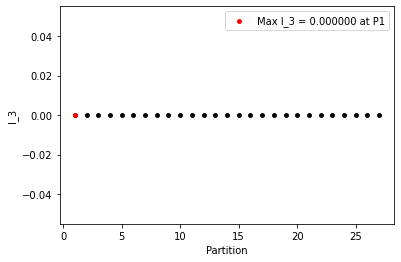


Case 2:

Given (gamma,lambda) = (0.98,-0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [-0. -0.  0.]
 [ 0.  0.  0.]]

Matrix B:
[[ 0.      0.     -0.      0.0002]
 [ 0.      0.     -0.      0.0001]
 [ 0.      0.      0.0001  0.0001]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Minimum value of the cost function:
-6.6981

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable a

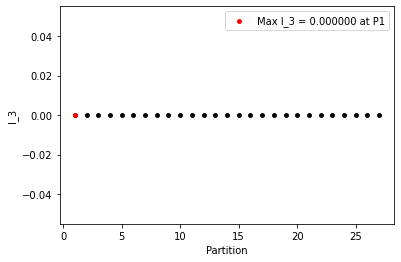


Case 3:

Given (gamma,lambda) = (0.98,0.0), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0.  0.]]

Matrix B:
[[ 0.0001  0.0001  0.      0.0001]
 [ 0.0001  0.0001 -0.      0.0001]
 [ 0.      0.0001  0.0001  0.0001]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Minimum value of the cost function:
-6.698

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable and 

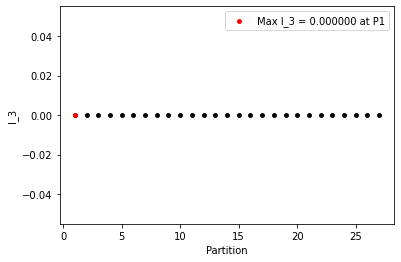


Case 4:

Given (gamma,lambda) = (0.98,0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Matrix B:
[[0.0001 0.0001 0.     0.0001]
 [0.0002 0.     0.     0.    ]
 [0.0001 0.     0.     0.0001]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Minimum value of the cost function:
-6.6979

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0



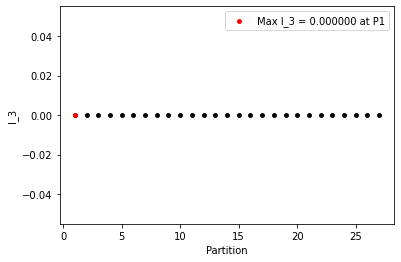


Case 5:

Given (gamma,lambda) = (0.98,0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0.  0.]
 [ 0. -0.  0.]]

Matrix B:
[[ 0.0001  0.      0.0001  0.0002]
 [ 0.     -0.      0.     -0.    ]
 [ 0.0001  0.      0.      0.0002]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Minimum value of the cost function:
-6.6979

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable an

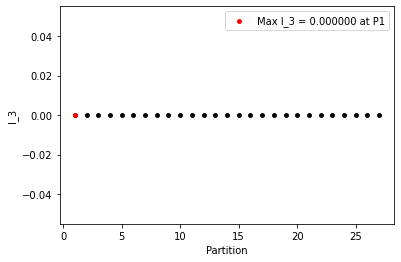


Case 6:

Given (gamma,lambda) = (0.99,-0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0. -0.]
 [ 0.  0. -0.]]

Matrix B:
[[ 0.0001  0.0003  0.0001  0.0003]
 [ 0.0001 -0.0001  0.0001  0.0002]
 [ 0.0001  0.0001 -0.     -0.0001]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]

Minimum value of the cost function:
-6.7665

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable a

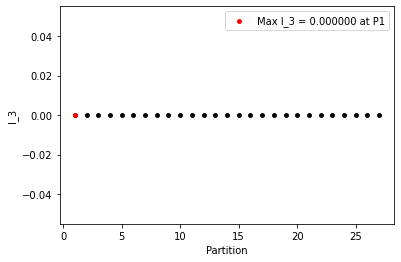


Case 7:

Given (gamma,lambda) = (0.99,-0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -0.]]

Matrix B:
[[ 0.0001  0.0002  0.0002  0.0003]
 [ 0.0001  0.0001  0.0001  0.0001]
 [ 0.0002  0.0001  0.0001 -0.    ]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Minimum value of the cost function:
-6.7665

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable a

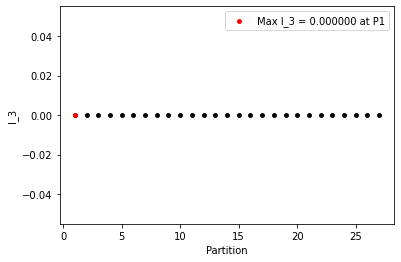


Case 8:

Given (gamma,lambda) = (0.99,0.0), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Matrix B:
[[0.0002 0.0001 0.0001 0.0002]
 [0.0001 0.0001 0.0001 0.    ]
 [0.0001 0.0002 0.0002 0.0002]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Minimum value of the cost function:
-6.7664

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0

C

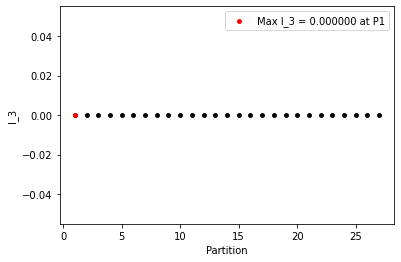


Case 9:

Given (gamma,lambda) = (0.99,0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0. -0.  0.]]

Matrix B:
[[-0.      0.0001  0.      0.0003]
 [ 0.0002  0.0002  0.     -0.0001]
 [ 0.0001  0.0003  0.0001  0.0001]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Minimum value of the cost function:
-6.7663

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.      0.     -0.    ]
 [ 0.      0.002   0.      0.    ]
 [ 0.      0.      0.0025  0.    ]
 [-0.      0.      0.      0.0016]]

Reconstruction error:
0.0

Mutual information between genera

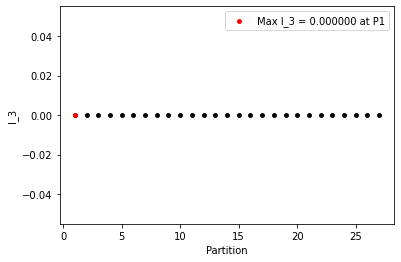


Case 10:

Given (gamma,lambda) = (0.99,0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.  0.  0.]
 [-0.  0.  0.]
 [-0.  0.  0.]
 [ 0. -0.  0.]]

Matrix B:
[[-0.     -0.     -0.      0.    ]
 [ 0.0001  0.0002  0.0001 -0.    ]
 [ 0.0002  0.0003  0.0002  0.0002]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]

Minimum value of the cost function:
-6.7662

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable a

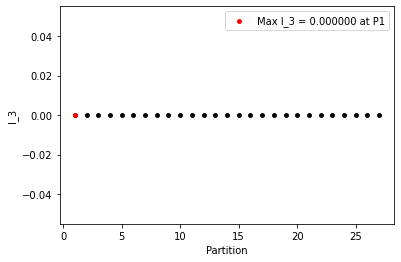


Case 11:

Given (gamma,lambda) = (1.0,-0.02), the reconstruction error = 1.074e-05 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.      0.     -0.    ]
 [ 0.0009 -0.0002  0.001 ]
 [-0.0003 -0.0002  0.0003]
 [-0.0002  0.0007  0.0004]]

Matrix B:
[[ 0.0176  0.4555 -0.131  -0.1535]
 [ 0.0174 -0.0993 -0.095   0.457 ]
 [-0.0126  0.4769  0.1058  0.2417]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 9.995e-01  2.000e-04 -3.000e-04]
 [ 2.000e-04  9.996e-01 -1.000e-04]
 [-3.000e-04 -1.000e-04  9.994e-01]]

Minimum value of the cost function:
-6.8349

Mutual information of the encoder:
0.00072506

Mutual information of the decoder:
0.00072517

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.     -0.      0.    ]
 [ 0.      0.002   0.     -0.    ]


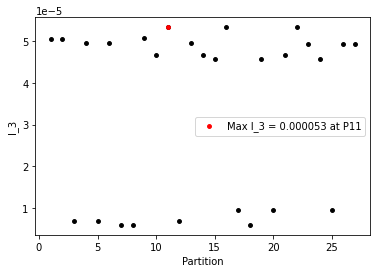


Case 12:

Given (gamma,lambda) = (1.0,-0.01), the reconstruction error = 2.93e-06 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.     -0.      0.    ]
 [ 0.0012 -0.0003  0.0008]
 [-0.     -0.0001  0.    ]
 [-0.0004  0.0006  0.0009]]

Matrix B:
[[-0.0076  0.594  -0.0129 -0.2743]
 [-0.0085 -0.1688 -0.0229  0.3955]
 [ 0.007   0.4181  0.01    0.5494]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 9.992e-01  4.000e-04 -3.000e-04]
 [ 4.000e-04  9.997e-01 -2.000e-04]
 [-3.000e-04 -2.000e-04  9.992e-01]]

Minimum value of the cost function:
-6.8348

Mutual information of the encoder:
0.00098455

Mutual information of the decoder:
0.00098462

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017 -0.      0.      0.    ]
 [-0.      0.002   0.      0.    ]
 

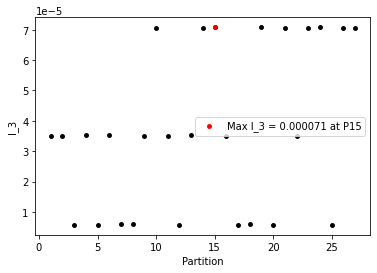


Case 13:

Given (gamma,lambda) = (1.0,0.0), the reconstruction error = 1.497e-05 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.      0.0001  0.    ]
 [ 0.0025 -0.0007  0.0004]
 [-0.0005 -0.0007  0.0024]
 [ 0.0001  0.0005  0.0002]]

Matrix B:
[[ 0.0079  1.241  -0.2199  0.0795]
 [ 0.0341 -0.3514 -0.284   0.3427]
 [ 0.012   0.1815  0.9536  0.1204]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[9.968e-01 7.000e-04 1.000e-04]
 [7.000e-04 9.994e-01 7.000e-04]
 [1.000e-04 7.000e-04 9.976e-01]]

Minimum value of the cost function:
-6.8347

Mutual information of the encoder:
0.00311068

Mutual information of the decoder:
0.00311068

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.      0.      0.    ]
 [ 0.      0.002   0.      0.    ]
 [ 0.      

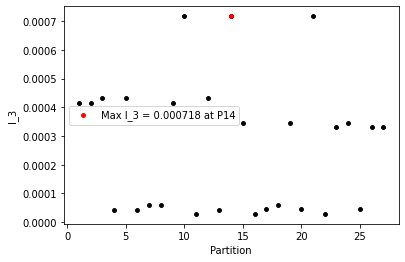


Case 14:

Given (gamma,lambda) = (1.0,0.01), the reconstruction error = 3.26e-06 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0006 -0.0002  0.001 ]
 [ 0.0006  0.0014  0.0007]
 [ 0.0105 -0.007   0.0055]
 [ 0.      0.     -0.    ]]

Matrix B:
[[-3.6630e-01  2.9530e-01  4.2098e+00  2.5000e-03]
 [-1.1080e-01  7.0360e-01 -2.7997e+00  1.2000e-03]
 [ 5.6190e-01  3.3150e-01  2.1921e+00 -3.2000e-03]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0023 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9553  0.029  -0.0229]
 [ 0.029   0.9794  0.015 ]
 [-0.0229  0.015   0.9872]]

Minimum value of the cost function:
-6.8346

Mutual information of the encoder:
0.04056101

Mutual information of the decoder:
0.04055754

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.      0.     -0.    ]
 [ 0.      0.002

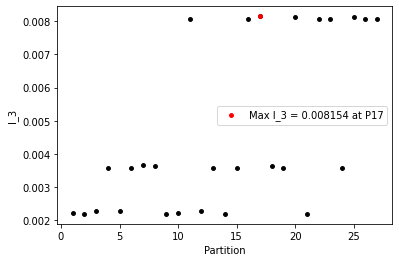


Case 15:

Given (gamma,lambda) = (1.0,0.02), the reconstruction error = 5.23e-06 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0023  0.0029 -0.0012]
 [-0.0001  0.0001  0.0001]
 [ 0.0016 -0.0006  0.0017]
 [ 0.     -0.     -0.    ]]

Matrix B:
[[ 1.3751 -0.0418  0.6581  0.0179]
 [ 1.7202  0.0601 -0.2467 -0.0255]
 [-0.7189  0.0639  0.6685 -0.0266]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 9.957e-01 -3.600e-03  6.000e-04]
 [-3.600e-03  9.948e-01  2.500e-03]
 [ 6.000e-04  2.500e-03  9.980e-01]]

Minimum value of the cost function:
-6.8346

Mutual information of the encoder:
0.00577098

Mutual information of the decoder:
0.00577014

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017 -0.      0.     -0.    ]
 [-0.      0.002   0.     -0.    ]
 [

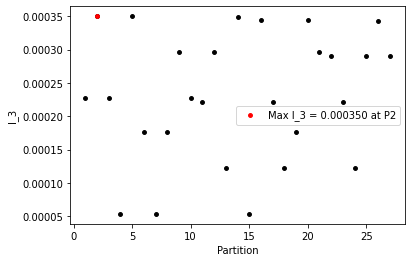


Case 16:

Given (gamma,lambda) = (1.01,-0.02), the reconstruction error = 0.00397009 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0286  0.016   0.0249]
 [ 0.032   0.0148  0.0273]
 [-0.      0.      0.    ]
 [ 0.0015  0.0343 -0.0203]]

Matrix B:
[[-16.9086  16.0858  -0.       0.9515]
 [  9.4398   7.414    0.      21.5576]
 [ 14.7024  13.7394   0.     -12.7469]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
66181.765

Mutual information of the encoder:
68.69320001

Mutual information of the decoder:
68.67081203

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.      0.      0.    ]
 [ 0.      0.002   0.      0.    ]
 [ 0.      0.     

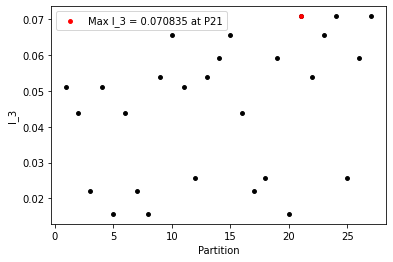


Case 17:

Given (gamma,lambda) = (1.01,-0.01), the reconstruction error = 0.00397017 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0026  0.0033  0.0409]
 [ 0.025   0.0367 -0.0046]
 [ 0.     -0.      0.    ]
 [ 0.033  -0.0225 -0.0003]]

Matrix B:
[[  1.551   12.5592   0.      20.6977]
 [  1.9715  18.4238  -0.     -14.1312]
 [ 24.1842  -2.3073   0.      -0.1754]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Minimum value of the cost function:
-9.6045

Mutual information of the encoder:
69.6490605

Mutual information of the decoder:
69.62667238

Value of Sigma_X:
[[ 1.005 -0.     0.   ]
 [-0.     1.005  0.   ]
 [ 0.     0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017 -0.      0.     -0.    ]
 [-0.      0.002  -0.      0.    ]
 [ 0.     -0.      0.0025  0. 

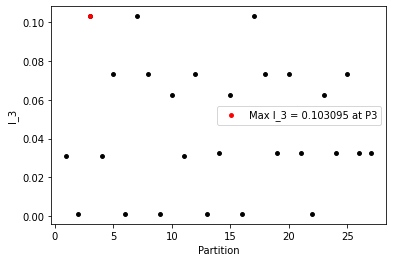


Case 18:

Given (gamma,lambda) = (1.01,0.0), the reconstruction error = 0.00397025 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0407  0.0013  0.0061]
 [-0.0065 -0.0016  0.0441]
 [ 0.     -0.     -0.    ]
 [-0.0015  0.0399  0.0012]]

Matrix B:
[[24.0346 -3.2834  0.     -0.9368]
 [ 0.7902 -0.797  -0.     25.0332]
 [ 3.5895 22.1603 -0.      0.7616]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0.  0.]
 [-0.  0.  0.]]

Minimum value of the cost function:
66181.7576

Mutual information of the encoder:
69.4459822

Mutual information of the decoder:
69.42359395

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005  0.   ]
 [-0.     0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.      0.     -0.    ]
 [ 0.      0.002  -0.      0.    ]
 [ 0.     -0.      0.0025 -0.   

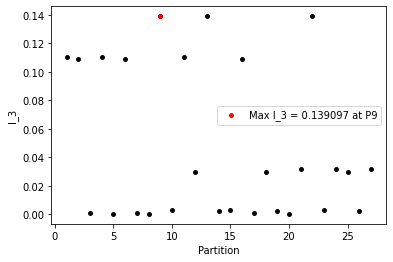


Case 19:

Given (gamma,lambda) = (1.01,0.01), the reconstruction error = 0.00496293 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0099  0.0399 -0.0008]
 [-0.      0.      0.    ]
 [ 0.0455 -0.011   0.0172]
 [-0.0132  0.004   0.0375]]

Matrix B:
[[ 5.8597 -0.     18.3025 -8.2601]
 [23.5925  0.     -4.4059  2.5288]
 [-0.4785  0.      6.8995 23.5264]]

Covariance matrix of Z:
[[0.    0.    0.    0.   ]
 [0.    0.002 0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]]

Covariance matrix of W:
[[ 0.  0.  0.]
 [ 0.  0. -0.]
 [ 0. -0.  0.]]

Minimum value of the cost function:
-33105.2778

Mutual information of the encoder:
68.9825924

Mutual information of the decoder:
68.96020401

Value of Sigma_X:
[[ 1.005 -0.     0.   ]
 [-0.     1.005 -0.   ]
 [ 0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.     -0.      0.    ]
 [ 0.      0.002  -0.      0.    ]
 [-0.     -0.      0.0025 -0.    ]
 [ 0.      

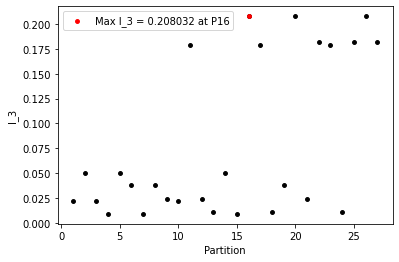


Case 20:

Given (gamma,lambda) = (1.01,0.02), the reconstruction error = 0.00496305 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.     -0.     -0.    ]
 [-0.0183 -0.0224  0.034 ]
 [-0.012   0.0431  0.022 ]
 [ 0.0351  0.0001  0.019 ]]

Matrix B:
[[ -0.      -9.1924  -4.8337  22.0451]
 [ -0.     -11.2607  17.3364   0.0701]
 [ -0.      17.0643   8.8364  11.9217]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-9.6014

Mutual information of the encoder:
69.35056658

Mutual information of the decoder:
69.32817804

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005  0.   ]
 [-0.     0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.     -0.     -0.    ]
 [ 0.      0.002   0.     -0.    ]
 [-0.      0.      0.

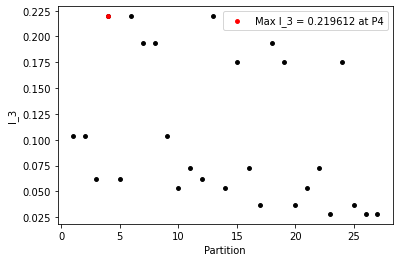


Case 21:

Given (gamma,lambda) = (1.02,-0.02), the reconstruction error = 0.00985198 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.024   0.0061  0.0327]
 [ 0.0124  0.0395 -0.0164]
 [-0.0379  0.0218  0.0237]
 [-0.      0.      0.    ]]

Matrix B:
[[ 14.2563   6.2517 -15.3137  -0.    ]
 [  3.6195  19.9263   8.7992   0.    ]
 [ 19.4357  -8.2966   9.5941   0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-11.8296

Mutual information of the encoder:
142.42774496

Mutual information of the decoder:
142.38318965

Value of Sigma_X:
[[ 1.01  0.    0.  ]
 [ 0.    1.01 -0.  ]
 [ 0.   -0.    1.01]]

Value of Sigma_Y_hat:
[[ 0.0017  0.      0.      0.    ]
 [ 0.      0.002  -0.      0.    ]
 [ 0.     -0.      0.0025 

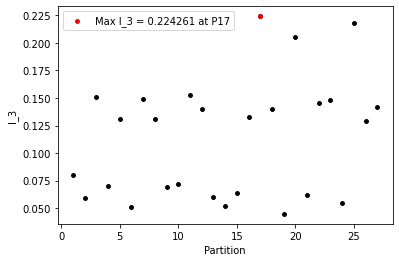


Case 22:

Given (gamma,lambda) = (1.02,-0.01), the reconstruction error = 0.00985222 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.034  -0.0149  0.0176]
 [ 0.     -0.      0.    ]
 [ 0.0151  0.0463  0.0101]
 [ 0.0188  0.0015 -0.0351]]

Matrix B:
[[ 20.1778   0.       6.0885  11.8621]
 [ -8.8333   0.      18.7174   0.9537]
 [ 10.4365   0.       4.0708 -22.1269]]

Covariance matrix of Z:
[[0.    0.    0.    0.   ]
 [0.    0.002 0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]]

Covariance matrix of W:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Minimum value of the cost function:
-11.8549

Mutual information of the encoder:
143.69285686

Mutual information of the decoder:
143.64830123

Value of Sigma_X:
[[ 1.01 -0.   -0.  ]
 [-0.    1.01 -0.  ]
 [-0.   -0.    1.01]]

Value of Sigma_Y_hat:
[[ 0.0017  0.     -0.     -0.    ]
 [ 0.      0.002   0.     -0.    ]
 [-0.      0.      0.0025  0.    ]
 [-0.     -0.   

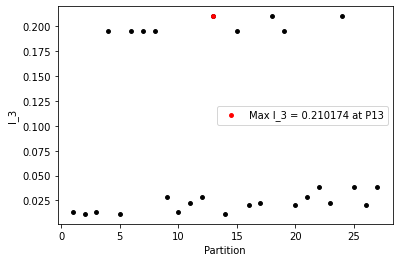


Case 23:

Given (gamma,lambda) = (1.02,0.0), the reconstruction error = 0.00985246 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0337 -0.0231 -0.0031]
 [ 0.0228  0.0352 -0.0148]
 [ 0.0123  0.0117  0.0468]
 [ 0.     -0.      0.    ]]

Matrix B:
[[ 20.044   11.5083   4.983    0.    ]
 [-13.7436  17.7935   4.7172  -0.    ]
 [ -1.8552  -7.4784  18.8917   0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-11.866

Mutual information of the encoder:
144.24561251

Mutual information of the decoder:
144.20105659

Value of Sigma_X:
[[ 1.01 -0.    0.  ]
 [-0.    1.01 -0.  ]
 [ 0.   -0.    1.01]]

Value of Sigma_Y_hat:
[[ 0.0017  0.      0.      0.    ]
 [ 0.      0.002  -0.     -0.    ]
 [ 0.     -0.      0.0025  0.

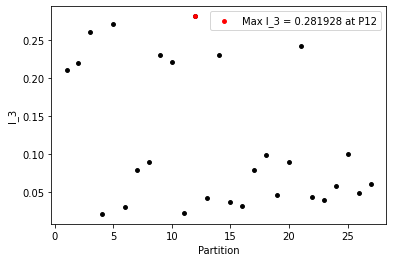


Case 24:

Given (gamma,lambda) = (1.02,0.01), the reconstruction error = 0.0098527 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0376  0.0137  0.0091]
 [ 0.      0.     -0.    ]
 [-0.01    0.0429 -0.0232]
 [-0.0138  0.0152  0.0341]]

Matrix B:
[[22.3245  0.     -4.0447 -8.725 ]
 [ 8.1406  0.     17.325   9.5821]
 [ 5.4255 -0.     -9.3523 21.5239]]

Covariance matrix of Z:
[[0.    0.    0.    0.   ]
 [0.    0.002 0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]]

Covariance matrix of W:
[[ 0. -0.  0.]
 [-0.  0. -0.]
 [ 0. -0.  0.]]

Minimum value of the cost function:
-3.94593387522215e+25

Mutual information of the encoder:
142.29548717

Mutual information of the decoder:
142.25093098

Value of Sigma_X:
[[ 1.01 -0.    0.  ]
 [-0.    1.01 -0.  ]
 [ 0.   -0.    1.01]]

Value of Sigma_Y_hat:
[[ 0.0017  0.      0.      0.    ]
 [ 0.      0.002   0.     -0.    ]
 [ 0.      0.      0.0025 -0.    ]
 [ 0.   

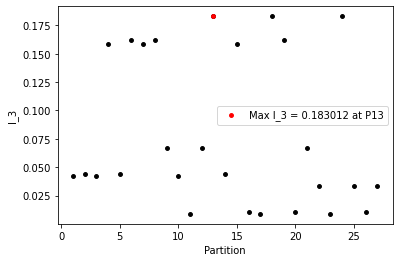


Case 25:

Given (gamma,lambda) = (1.02,0.02), the reconstruction error = 0.00985294 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0281 -0.0055  0.0294]
 [-0.0171  0.0341  0.0228]
 [ 0.0308  0.0312 -0.0236]
 [-0.      0.      0.    ]]

Matrix B:
[[16.6943 -8.6562 12.4306 -0.    ]
 [-3.2863 17.2392 12.6049  0.    ]
 [17.4525 11.5263 -9.5171  0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-11.8289

Mutual information of the encoder:
142.39313399

Mutual information of the decoder:
142.34857748

Value of Sigma_X:
[[ 1.01  0.   -0.  ]
 [ 0.    1.01 -0.  ]
 [-0.   -0.    1.01]]

Value of Sigma_Y_hat:
[[ 0.0017  0.     -0.      0.    ]
 [ 0.      0.002  -0.      0.    ]
 [-0.     -0.      0.0025 -0.    ]
 [ 0

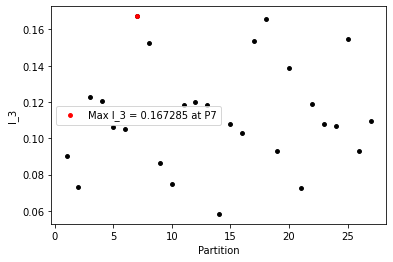

Scenario 2:
Given (sigma_v1, sigma_v3) = (0.01, 0.03), alpha = 2, and sigma_z2 = 0.02:

Covariance matrix of generative variable V:
[[ 0.0001  0.0002 -0.    ]
 [ 0.0002  0.0008 -0.    ]
 [-0.     -0.      0.0009]]
The matrix is not singular.

Covariance matrix of input data Y:
[[0.0017 0.0002 0.     0.    ]
 [0.0002 0.0024 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]
The matrix is positive definite.

Case 1:

Given (gamma,lambda) = (0.98,-0.02), the reconstruction error = 0.01522543 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0104  0.0026  0.0047]
 [ 0.0123  0.0031  0.0055]
 [ 0.      0.     -0.    ]
 [ 0.     -0.     -0.    ]]

Matrix B:
[[ 5.5551  4.672   0.      0.    ]
 [ 1.4083  1.1844  0.     -0.    ]
 [ 2.496   2.0992 -0.     -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0

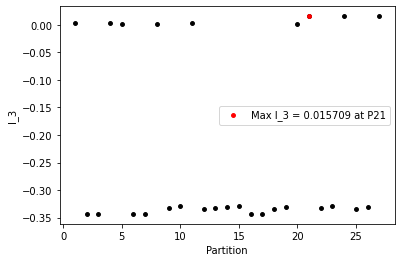


Case 2:

Given (gamma,lambda) = (0.98,-0.01), the reconstruction error = 0.01519563 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0026  0.001   0.0113]
 [ 0.0031  0.0012  0.0135]
 [-0.      0.      0.    ]
 [-0.      0.     -0.    ]]

Matrix B:
[[ 1.4119  1.1879 -0.     -0.    ]
 [ 0.5439  0.4576  0.      0.    ]
 [ 6.0652  5.1028  0.     -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9926 -0.0029 -0.032 ]
 [-0.0029  0.9989 -0.0123]
 [-0.032  -0.0123  0.8626]]

Minimum value of the cost function:
-6.6118

Mutual information of the encoder:
0.07888997

Mutual information of the decoder:
0.08038003

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.0002 0.     0.    ]
 [0.0002 0.0024 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0

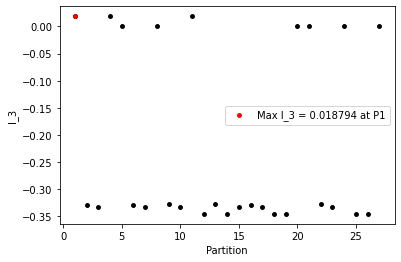


Case 3:

Given (gamma,lambda) = (0.98,0.0), the reconstruction error = 0.01516584 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0082  0.0063  0.0055]
 [ 0.0097  0.0074  0.0065]
 [ 0.     -0.      0.    ]
 [ 0.      0.     -0.    ]]

Matrix B:
[[ 4.3819  3.688   0.      0.    ]
 [ 3.3525  2.8215 -0.      0.    ]
 [ 2.9393  2.4738  0.     -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9283 -0.0549 -0.0481]
 [-0.0549  0.958  -0.0368]
 [-0.0481 -0.0368  0.9677]]

Minimum value of the cost function:
-6.6117

Mutual information of the encoder:
0.07892925

Mutual information of the decoder:
0.08041713

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.      0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [-0.     -0.      0.0025 -0

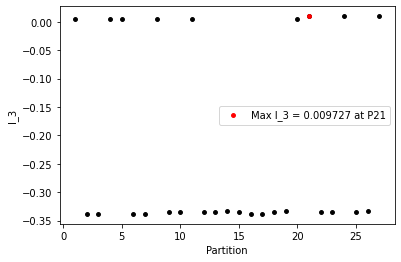


Case 4:

Given (gamma,lambda) = (0.98,0.01), the reconstruction error = 0.01513606 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.007   0.0035  0.0087]
 [ 0.0083  0.0041  0.0104]
 [-0.     -0.      0.    ]
 [ 0.      0.     -0.    ]]

Matrix B:
[[ 3.7234  3.1348 -0.      0.    ]
 [ 1.8627  1.5683 -0.      0.    ]
 [ 4.6638  3.9266  0.     -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9482 -0.0259 -0.0649]
 [-0.0259  0.987  -0.0325]
 [-0.0649 -0.0325  0.9187]]

Minimum value of the cost function:
-6.6117

Mutual information of the encoder:
0.07896853

Mutual information of the decoder:
0.08045424

Value of Sigma_X:
[[ 1. -0.  0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.      0.    ]
 [ 0.0002  0.0024  0.     -0.    ]
 [-0.      0.      0.0025 -

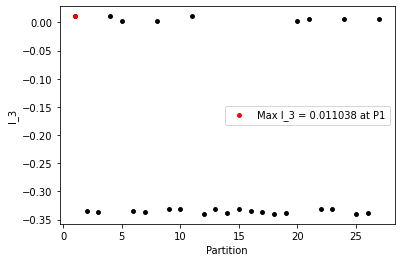


Case 5:

Given (gamma,lambda) = (0.98,0.02), the reconstruction error = 0.01510628 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0096  0.0028  0.0061]
 [ 0.0114  0.0033  0.0072]
 [-0.     -0.      0.    ]
 [ 0.      0.     -0.    ]]

Matrix B:
[[ 5.1288  4.3196 -0.      0.    ]
 [ 1.5035  1.2663 -0.      0.    ]
 [ 3.244   2.7321  0.     -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9016 -0.0288 -0.0622]
 [-0.0288  0.9915 -0.0182]
 [-0.0622 -0.0182  0.9607]]

Minimum value of the cost function:
-6.6116

Mutual information of the encoder:
0.07900782

Mutual information of the decoder:
0.08049134

Value of Sigma_X:
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.     -0.    ]
 [ 0.0002  0.0024 -0.      0.    ]
 [-0.     -0.      0.0025 -

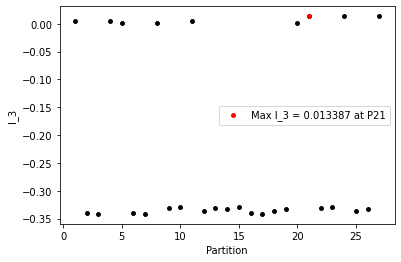


Case 6:

Given (gamma,lambda) = (0.99,-0.02), the reconstruction error = 0.00748475 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0082  0.0012  0.0092]
 [ 0.0097  0.0014  0.0109]
 [ 0.      0.     -0.    ]
 [ 0.      0.     -0.    ]]

Matrix B:
[[ 4.368   3.6711  0.      0.    ]
 [ 0.6394  0.5374  0.      0.    ]
 [ 4.9278  4.1416 -0.     -0.    ]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9288 -0.0104 -0.0803]
 [-0.0104  0.9985 -0.0118]
 [-0.0803 -0.0118  0.9094]]

Minimum value of the cost function:
-6.6802

Mutual information of the encoder:
0.0891628

Mutual information of the decoder:
0.08999323

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[0.0017 0.0002 0.     0.    ]
 [0.0002 0.0024 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.  

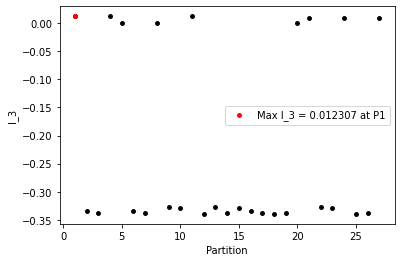


Case 7:

Given (gamma,lambda) = (0.99,-0.01), the reconstruction error = 0.00745645 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.01    0.0058  0.0043]
 [ 0.0119  0.0069  0.0051]
 [-0.      0.     -0.    ]
 [-0.      0.     -0.    ]]

Matrix B:
[[ 5.362   4.5097 -0.     -0.    ]
 [ 3.1045  2.611   0.      0.    ]
 [ 2.317   1.9487 -0.     -0.    ]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.8926 -0.0622 -0.0464]
 [-0.0622  0.964  -0.0269]
 [-0.0464 -0.0269  0.98  ]]

Minimum value of the cost function:
-6.6801

Mutual information of the encoder:
0.08920083

Mutual information of the decoder:
0.09002848

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.      0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [ 0.     -0.      0.0025  0.    ]


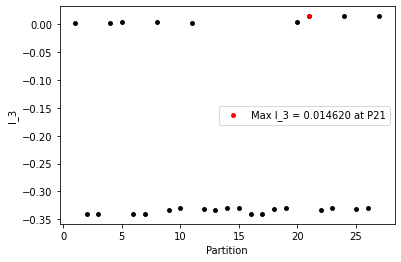


Case 8:

Given (gamma,lambda) = (0.99,0.0), the reconstruction error = 0.00742817 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.007   0.0039  0.0094]
 [ 0.0083  0.0046  0.0112]
 [ 0.     -0.     -0.    ]
 [-0.      0.      0.    ]]

Matrix B:
[[ 3.734   3.1426  0.     -0.    ]
 [ 2.0668  1.7394 -0.      0.    ]
 [ 5.0527  4.2525 -0.      0.    ]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9479 -0.0288 -0.0705]
 [-0.0288  0.984  -0.039 ]
 [-0.0705 -0.039   0.9046]]

Minimum value of the cost function:
-6.6801

Mutual information of the encoder:
0.0892389

Mutual information of the decoder:
0.09006376

Value of Sigma_X:
[[ 1. -0. -0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.      0.    ]
 [ 0.0002  0.0024  0.     -0.    ]
 [-0.      0.      0.0025 -0.

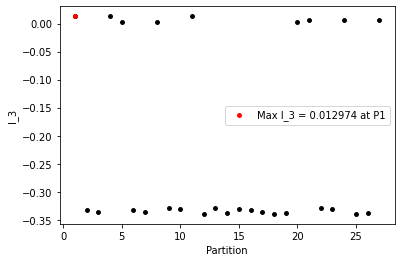


Case 9:

Given (gamma,lambda) = (0.99,0.01), the reconstruction error = 0.00739988 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0078  0.0015  0.0095]
 [ 0.0092  0.0018  0.0113]
 [-0.      0.      0.    ]
 [-0.      0.      0.    ]]

Matrix B:
[[ 4.1638  3.5068 -0.     -0.    ]
 [ 0.8056  0.6785  0.      0.    ]
 [ 5.0739  4.2733  0.      0.    ]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9352 -0.0125 -0.079 ]
 [-0.0125  0.9976 -0.0153]
 [-0.079  -0.0153  0.9037]]

Minimum value of the cost function:
-6.68

Mutual information of the encoder:
0.08927699

Mutual information of the decoder:
0.09009907

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.      0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [-0.     -0.      0.0025  0.    ]
 [ 

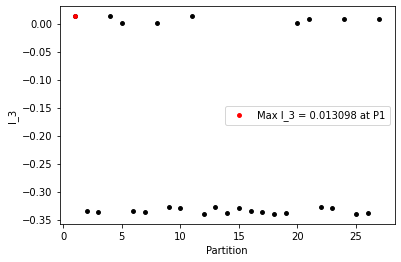


Case 10:

Given (gamma,lambda) = (0.99,0.02), the reconstruction error = 0.0073716 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0101  0.0059  0.004 ]
 [ 0.012   0.0071  0.0047]
 [-0.      0.      0.    ]
 [-0.     -0.      0.    ]]

Matrix B:
[[ 5.3924  4.5448 -0.     -0.    ]
 [ 3.1803  2.6804  0.     -0.    ]
 [ 2.127   1.7926  0.      0.    ]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.8912 -0.0642 -0.0429]
 [-0.0642  0.9622 -0.0253]
 [-0.0429 -0.0253  0.9831]]

Minimum value of the cost function:
-6.6799

Mutual information of the encoder:
0.08931512

Mutual information of the decoder:
0.09013441

Value of Sigma_X:
[[ 1. -0.  0.]
 [ 0.  1.  0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.      0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [ 0.     -0.      0.0025  

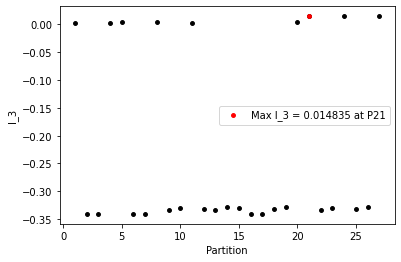


Case 11:

Given (gamma,lambda) = (1.0,-0.02), the reconstruction error = 5.384e-05 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0116  0.0018  0.0064]
 [ 0.0129  0.0019  0.0071]
 [ 0.0001 -0.0003 -0.0002]
 [ 0.0001  0.0003 -0.0002]]

Matrix B:
[[ 6.2768  4.8633  0.0573  0.0516]
 [ 0.9446  0.7324 -0.1379  0.1576]
 [ 3.4774  2.6791 -0.066  -0.1362]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.864  -0.0205 -0.0751]
 [-0.0205  0.9968 -0.0113]
 [-0.0751 -0.0113  0.9585]]

Minimum value of the cost function:
-6.7486

Mutual information of the encoder:
0.09962591

Mutual information of the decoder:
0.09963246

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.     -0.    ]
 [ 0.0002  0.0024  0.      0.    ]
 [-0.      0.      0.0025 -0.    ]
 

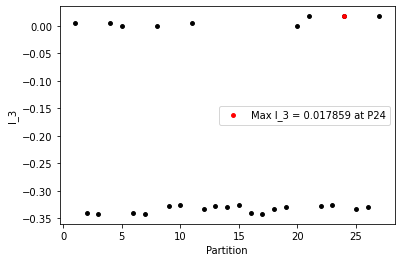


Case 12:

Given (gamma,lambda) = (1.0,-0.01), the reconstruction error = 2.692e-05 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0124 -0.0007  0.0043]
 [ 0.0144 -0.0008  0.0049]
 [-0.0099 -0.0019  0.0284]
 [-0.     -0.0001 -0.    ]]

Matrix B:
[[ 6.66610e+00  5.42380e+00 -3.95460e+00 -1.80000e-03]
 [-3.85200e-01 -3.16400e-01 -7.48300e-01 -5.66000e-02]
 [ 2.29620e+00  1.86810e+00  1.13552e+01 -4.40000e-03]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[0.8003 0.0019 0.0569]
 [0.0019 0.9981 0.0245]
 [0.0569 0.0245 0.6586]]

Minimum value of the cost function:
-6.7486

Mutual information of the encoder:
0.32472746

Mutual information of the decoder:
0.32474078

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.     -0.    ]
 [ 0.0002  

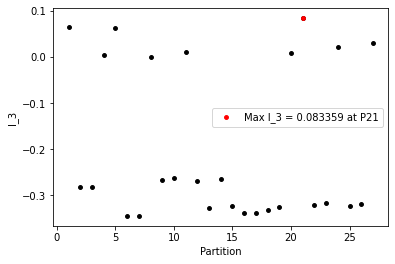


Case 13:

Given (gamma,lambda) = (1.0,0.0), the reconstruction error = 2.25e-06 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0057  0.0048  0.0107]
 [ 0.0066  0.0056  0.0125]
 [-0.0001 -0.0003  0.0002]
 [-0.0011  0.0006  0.0003]]

Matrix B:
[[ 3.055   2.5151 -0.0564 -0.6779]
 [ 2.5969  2.1354 -0.1326  0.4004]
 [ 5.7614  4.7478  0.0896  0.179 ]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9651 -0.0286 -0.0642]
 [-0.0286  0.9751 -0.0548]
 [-0.0642 -0.0548  0.8785]]

Minimum value of the cost function:
-6.7485

Mutual information of the encoder:
0.09991705

Mutual information of the decoder:
0.09991705

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.      0.    ]
 [ 0.0002  0.0024  0.     -0.    ]
 [-0.      0.      0.0025  0. 

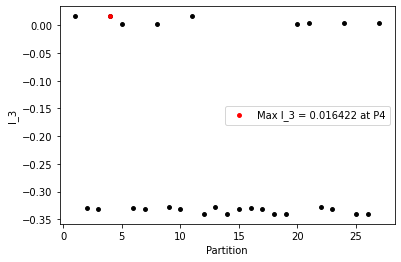


Case 14:

Given (gamma,lambda) = (1.0,0.01), the reconstruction error = 2.636e-05 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0093  0.0015  0.0077]
 [ 0.0125  0.002   0.0104]
 [ 0.0001  0.0002 -0.0001]
 [-0.0068  0.006   0.0071]]

Matrix B:
[[ 4.9236  4.8079  0.0202 -4.2591]
 [ 0.7874  0.7639  0.0661  3.7779]
 [ 4.0771  3.9857 -0.0371  4.4137]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0021 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0015]]

Covariance matrix of W:
[[ 0.8648  0.0088 -0.0579]
 [ 0.0088  0.9745 -0.0407]
 [-0.0579 -0.0407  0.8959]]

Minimum value of the cost function:
-6.7484

Mutual information of the encoder:
0.14363437

Mutual information of the decoder:
0.14362848

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.     -0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [ 0.     -0.      0.0025  0

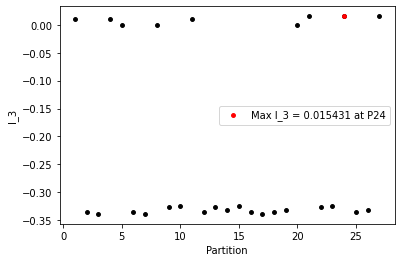


Case 15:

Given (gamma,lambda) = (1.0,0.02), the reconstruction error = 5.293e-05 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0004  0.0043  0.0115]
 [ 0.0006  0.0057  0.0152]
 [-0.0003 -0.0003  0.0001]
 [ 0.001  -0.0008  0.0003]]

Matrix B:
[[ 0.2331  0.2201 -0.1085  0.6406]
 [ 2.2629  2.1674 -0.1275 -0.5125]
 [ 6.09    5.8453  0.0514  0.1659]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0021 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9991 -0.0018 -0.0062]
 [-0.0018  0.9776 -0.059 ]
 [-0.0062 -0.059   0.8407]]

Minimum value of the cost function:
-6.7483

Mutual information of the encoder:
0.10071798

Mutual information of the decoder:
0.10071087

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.     -0.    ]
 [ 0.0002  0.0024  0.      0.    ]
 [-0.      0.      0.0025  0

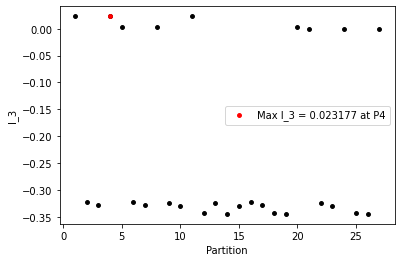


Case 16:

Given (gamma,lambda) = (1.01,-0.02), the reconstruction error = 0.00486895 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.023  -0.0033  0.0339]
 [ 0.0415  0.0153 -0.0208]
 [-0.      0.     -0.    ]
 [ 0.009  -0.0376 -0.0097]]

Matrix B:
[[ 11.6745  16.4     -0.       5.6568]
 [ -2.7193   6.6391   0.     -23.636 ]
 [ 21.2916 -10.4812   0.      -6.1204]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0.  0.]
 [-0.  0.  0.]]

Minimum value of the cost function:
49634.0152

Mutual information of the encoder:
68.39022802

Mutual information of the decoder:
68.36784018

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.     -0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [-0.     -0.    

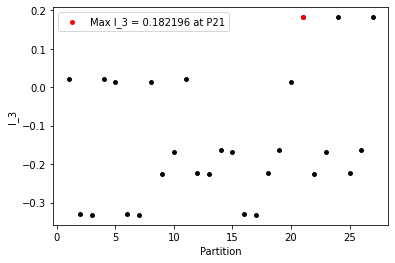


Case 17:

Given (gamma,lambda) = (1.01,-0.01), the reconstruction error = 0.00496269 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0175  0.0135  0.0346]
 [ 0.0021  0.0016  0.0041]
 [-0.0364 -0.0211  0.0267]
 [-0.0213  0.0337 -0.0024]]

Matrix B:
[[ 10.3684   0.     -14.6511 -13.3602]
 [  8.0075   0.      -8.4904  21.1508]
 [ 20.4828   0.      10.7356  -1.5056]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0024 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-33105.1908

Mutual information of the encoder:
68.99103837

Mutual information of the decoder:
68.96865052

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.     -0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [-0.     -0.   

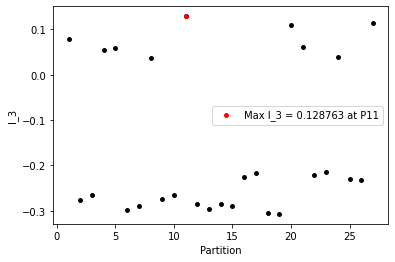


Case 18:

Given (gamma,lambda) = (1.01,0.0), the reconstruction error = 0.00496281 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0011  0.0022  0.0032]
 [ 0.0133  0.0267  0.0387]
 [ 0.0474 -0.0015 -0.0153]
 [ 0.0058 -0.0334  0.0211]]

Matrix B:
[[  0.       5.5788  19.0723   3.6152]
 [  0.      11.198   -0.6014 -20.9633]
 [  0.      16.1934  -6.1548  13.2509]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.  0.]
 [-0.  0. -0.]
 [ 0. -0.  0.]]

Minimum value of the cost function:
-132392.2343

Mutual information of the encoder:
69.34348297

Mutual information of the decoder:
69.32109497

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[0.0017 0.0002 0.     0.    ]
 [0.0002 0.0024 0.     0.    ]
 [0.     0.     0.0025 0.

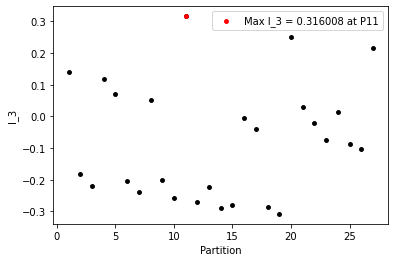


Case 19:

Given (gamma,lambda) = (1.01,0.01), the reconstruction error = 0.00496293 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0361  0.0194  0.0029]
 [ 0.0125 -0.0195  0.043 ]
 [ 0.0223 -0.0379 -0.0237]
 [-0.     -0.     -0.    ]]

Matrix B:
[[ 20.9496   3.4987   8.9485  -0.    ]
 [ 12.569   -9.219  -15.2157   0.    ]
 [ -0.3976  18.046   -9.508   -0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0.  0.]
 [-0.  0.  0.]]

Minimum value of the cost function:
-33105.1896

Mutual information of the encoder:
68.8717579

Mutual information of the decoder:
68.84936962

Value of Sigma_X:
[[ 1.005  0.    -0.   ]
 [ 0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.     -0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [-0.     -0.     

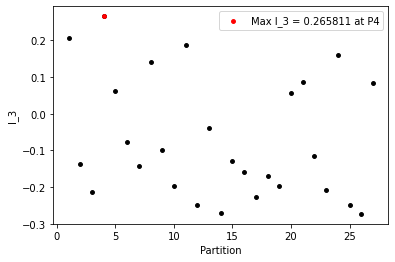


Case 20:

Given (gamma,lambda) = (1.01,0.02), the reconstruction error = 0.00496305 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0003  0.0032  0.0025]
 [-0.0037  0.0385  0.0299]
 [ 0.0358 -0.0191  0.029 ]
 [ 0.0276  0.0193 -0.0214]]

Matrix B:
[[ -0.      -1.5527  14.3863  17.3528]
 [  0.      16.1013  -7.6879  12.1199]
 [  0.      12.5333  11.6588 -13.4204]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-198583.6008

Mutual information of the encoder:
69.99428259

Mutual information of the decoder:
69.97189428

Value of Sigma_X:
[[ 1.005  0.     0.   ]
 [ 0.     1.005 -0.   ]
 [ 0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.     -0.    ]
 [ 0.0002  0.0024  0.     -0.    ]
 [ 0.      0.   

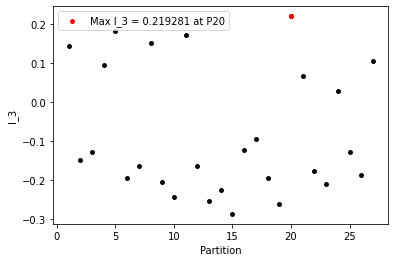


Case 21:

Given (gamma,lambda) = (1.02,-0.02), the reconstruction error = 0.00985198 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0385  0.0124 -0.007 ]
 [ 0.0072  0.0187  0.0444]
 [ 0.0171 -0.044   0.0158]
 [-0.      0.      0.    ]]

Matrix B:
[[ 22.7232   1.1415   6.8895   0.    ]
 [  6.5061   7.3276 -17.777    0.    ]
 [ -6.4263  19.2349   6.3634   0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-11.7496

Mutual information of the encoder:
142.82381012

Mutual information of the decoder:
142.77925557

Value of Sigma_X:
[[ 1.01   -0.     -0.    ]
 [-0.      1.0099 -0.    ]
 [-0.     -0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.      0.    ]
 [ 0.0002  0.0024  0.      0.    ]
 [-0.   

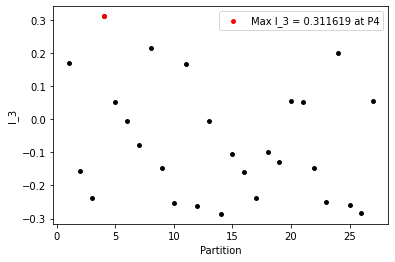


Case 22:

Given (gamma,lambda) = (1.02,-0.01), the reconstruction error = 0.00985222 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0272 -0.0052  0.0303]
 [ 0.0271  0.0389 -0.0111]
 [-0.028   0.0281  0.0301]
 [-0.     -0.     -0.    ]]

Matrix B:
[[ 14.9703  10.1695 -11.3112  -0.    ]
 [ -5.0919  16.8134  11.3431  -0.    ]
 [ 18.7065  -6.2347  12.1396  -0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0.  0.]
 [-0.  0.  0.]]

Minimum value of the cost function:
-11.7041

Mutual information of the encoder:
140.55033253

Mutual information of the decoder:
140.50577746

Value of Sigma_X:
[[ 1.0099 -0.     -0.    ]
 [-0.      1.01   -0.    ]
 [-0.     -0.      1.01  ]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.     -0.    ]
 [ 0.0002  0.0024  0.     -0.    ]
 [-0.   

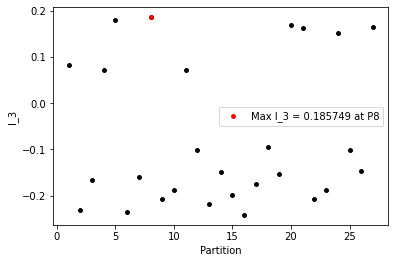


Case 23:

Given (gamma,lambda) = (1.02,0.0), the reconstruction error = 0.00985246 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0148  0.0307  0.0228]
 [ 0.0405 -0.0234  0.0137]
 [-0.0239 -0.018   0.0397]
 [ 0.     -0.     -0.    ]]

Matrix B:
[[  6.8738  16.4771  -9.6485   0.    ]
 [ 19.5768 -11.4635  -7.2884  -0.    ]
 [ 13.018    4.6981  16.0551  -0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0. -0.  0.]
 [-0.  0.  0.]
 [ 0.  0.  0.]]

Minimum value of the cost function:
-3.94593387522215e+25

Mutual information of the encoder:
142.66999067

Mutual information of the decoder:
142.62543528

Value of Sigma_X:
[[ 1.0099 -0.     -0.    ]
 [-0.      1.01    0.    ]
 [-0.      0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.     -0.    ]
 [ 0.0002  0.0024  0.      0.   

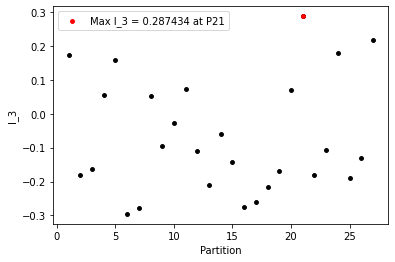


Case 24:

Given (gamma,lambda) = (1.02,0.01), the reconstruction error = 0.0098527 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0274  0.0011  0.0305]
 [ 0.0334  0.0256 -0.0245]
 [ 0.0202 -0.0423 -0.0167]
 [ 0.      0.     -0.    ]]

Matrix B:
[[ 14.7919  12.8412   8.1549   0.    ]
 [ -0.6384  10.8384 -17.0891   0.    ]
 [ 19.5132 -11.942   -6.7409  -0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0.  0.]
 [-0.  0.  0.]]

Minimum value of the cost function:
-7.8918677504443e+25

Mutual information of the encoder:
142.97413603

Mutual information of the decoder:
142.92958032

Value of Sigma_X:
[[ 1.0099 -0.     -0.    ]
 [-0.      1.01   -0.    ]
 [-0.     -0.      1.01  ]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.      0.    ]
 [ 0.0002  0.0024 -0.      0.    

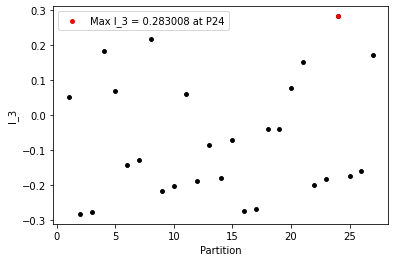


Case 25:

Given (gamma,lambda) = (1.02,0.02), the reconstruction error = 0.00985294 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0309 -0.0004 -0.0269]
 [ 0.0355 -0.0015  0.0334]
 [ 0.0013  0.0497  0.0007]
 [ 0.     -0.      0.    ]]

Matrix B:
[[ 16.7874  13.5291   0.5388   0.    ]
 [ -0.1827  -0.596   20.0898  -0.    ]
 [-17.8359  15.5431   0.3013   0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0.  0.]
 [-0.  0.  0.]]

Minimum value of the cost function:
-7.8918677504443e+25

Mutual information of the encoder:
142.8761566

Mutual information of the decoder:
142.8316006

Value of Sigma_X:
[[ 1.0099  0.     -0.    ]
 [ 0.      1.01   -0.    ]
 [-0.     -0.      1.01  ]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.      0.    ]
 [ 0.0002  0.0024 -0.      0.    ]

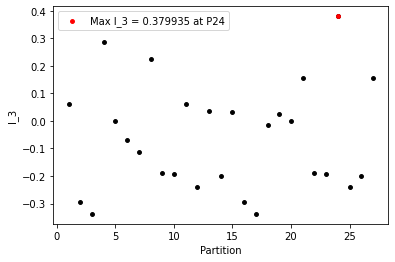

Scenario 3:
Given sigma_v1 = 0.01, (alpha, beta) = (2, 4), and (sigma_z2, sigma_z3) = (0.02, 0.03):

Covariance matrix of generative variable V:
[[0.0001 0.0002 0.0004]
 [0.0002 0.0008 0.0008]
 [0.0004 0.0008 0.0025]]
The matrix is not singular.

Covariance matrix of input data Y:
[[0.0017 0.0002 0.0004 0.    ]
 [0.0002 0.0024 0.0008 0.    ]
 [0.0004 0.0008 0.0041 0.    ]
 [0.     0.     0.     0.0016]]
The matrix is positive definite.

Case 1:

Given (gamma,lambda) = (0.98,-0.02), the reconstruction error = 0.01517876 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0012  0.0055  0.0087]
 [-0.0024  0.0113  0.0179]
 [-0.004   0.0188  0.0297]
 [-0.      0.     -0.    ]]

Matrix B:
[[-0.4211 -0.7124 -0.8071 -0.    ]
 [ 1.9548  3.307   3.7468  0.    ]
 [ 3.0898  5.2272  5.9223 -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0019 0.     0.    ]
 [0.     0.     0.0028 0.    ]
 [0.     0.     0.    

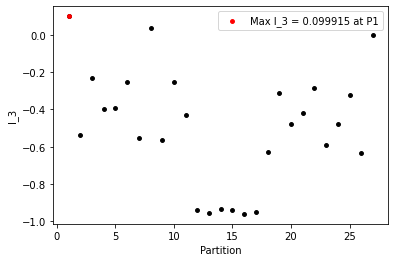


Case 2:

Given (gamma,lambda) = (0.98,-0.01), the reconstruction error = 0.01514335 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0101  0.0006  0.002 ]
 [ 0.0209  0.0013  0.0041]
 [ 0.0347  0.0022  0.0068]
 [-0.     -0.      0.    ]]

Matrix B:
[[ 3.6036  6.0959  6.9112 -0.    ]
 [ 0.2239  0.3788  0.4295 -0.    ]
 [ 0.7098  1.2007  1.3613  0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0019 0.     0.    ]
 [0.     0.     0.0028 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.5968 -0.0251 -0.0794]
 [-0.0251  0.9984 -0.0049]
 [-0.0794 -0.0049  0.9844]]

Minimum value of the cost function:
-6.4068

Mutual information of the encoder:
0.27271988

Mutual information of the decoder:
0.27700215

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  0.    ]


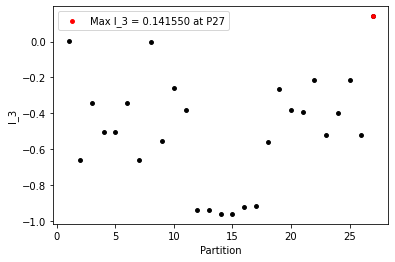


Case 3:

Given (gamma,lambda) = (0.98,0.0), the reconstruction error = 0.01510793 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0051  0.0019  0.0088]
 [ 0.0106  0.0039  0.0181]
 [ 0.0176  0.0064  0.03  ]
 [ 0.      0.     -0.    ]]

Matrix B:
[[ 1.8312  3.0974  3.5141  0.    ]
 [ 0.6658  1.1261  1.2776  0.    ]
 [ 3.1206  5.2782  5.9883 -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0019 0.     0.    ]
 [0.     0.     0.0028 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.8958 -0.0379 -0.1775]
 [-0.0379  0.9862 -0.0645]
 [-0.1775 -0.0645  0.6974]]

Minimum value of the cost function:
-6.4067

Mutual information of the encoder:
0.27280613

Mutual information of the decoder:
0.27707877

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  0

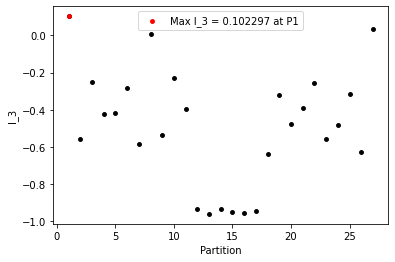


Case 4:

Given (gamma,lambda) = (0.98,0.01), the reconstruction error = 0.01507249 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.      0.0052  0.0089]
 [ 0.0001  0.0108  0.0184]
 [ 0.0001  0.0179  0.0306]
 [-0.      0.     -0.    ]]

Matrix B:
[[ 0.0156  0.0263  0.0299 -0.    ]
 [ 1.8552  3.1376  3.5621  0.    ]
 [ 3.1761  5.3715  6.0984 -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0019 0.     0.    ]
 [0.     0.     0.0028 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1.000e+00 -9.000e-04 -1.500e-03]
 [-9.000e-04  8.930e-01 -1.832e-01]
 [-1.500e-03 -1.832e-01  6.864e-01]]

Minimum value of the cost function:
-6.4067

Mutual information of the encoder:
0.2728925

Mutual information of the decoder:
0.27715552

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008  0.    ]
 [ 0.0004 

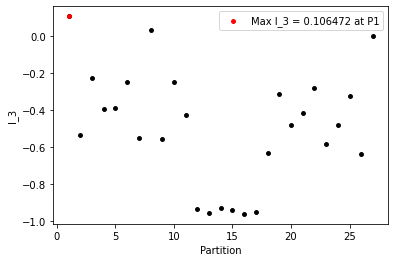


Case 5:

Given (gamma,lambda) = (0.98,0.02), the reconstruction error = 0.01503704 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0083  0.0062  0.0005]
 [ 0.0171  0.0127  0.001 ]
 [ 0.0283  0.0212  0.0016]
 [ 0.     -0.      0.    ]]

Matrix B:
[[ 2.9425  4.9759  5.6531  0.    ]
 [ 2.1994  3.7193  4.2255 -0.    ]
 [ 0.1696  0.2869  0.3259  0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0019 0.     0.    ]
 [0.     0.     0.0028 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.7307 -0.2013 -0.0155]
 [-0.2013  0.8495 -0.0116]
 [-0.0155 -0.0116  0.9991]]

Minimum value of the cost function:
-6.4066

Mutual information of the encoder:
0.272979

Mutual information of the decoder:
0.2772324

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  0. 

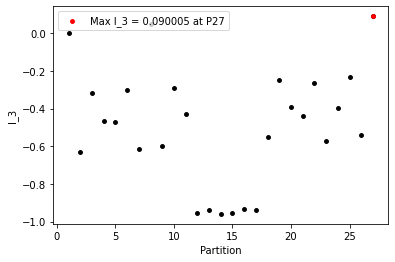


Case 6:

Given (gamma,lambda) = (0.99,-0.02), the reconstruction error = 0.00878012 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0018  0.005   0.0088]
 [-0.0038  0.0102  0.018 ]
 [-0.0066  0.018   0.0316]
 [ 0.     -0.      0.    ]]

Matrix B:
[[-0.6416 -1.0679 -1.3497  0.    ]
 [ 1.7357  2.8881  3.6507 -0.    ]
 [ 3.0565  5.0859  6.4288  0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0027 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9858  0.0383  0.0675]
 [ 0.0383  0.8963 -0.1827]
 [ 0.0675 -0.1827  0.6783]]

Minimum value of the cost function:
-6.4751

Mutual information of the encoder:
0.28952298

Mutual information of the decoder:
0.29175969

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041 

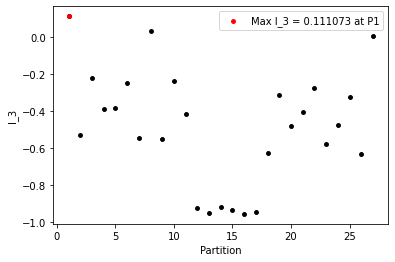


Case 7:

Given (gamma,lambda) = (0.99,-0.01), the reconstruction error = 0.00873896 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0008  0.0046  0.0091]
 [ 0.0016  0.0095  0.0186]
 [ 0.0028  0.0168  0.0329]
 [ 0.     -0.      0.    ]]

Matrix B:
[[ 0.2726  0.4519  0.5725  0.    ]
 [ 1.6171  2.6908  3.4045 -0.    ]
 [ 3.1732  5.279   6.6797  0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0027 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9975 -0.0152 -0.0297]
 [-0.0152  0.9099 -0.1769]
 [-0.0297 -0.1769  0.653 ]]

Minimum value of the cost function:
-6.4751

Mutual information of the encoder:
0.28964527

Mutual information of the decoder:
0.29187188

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041 

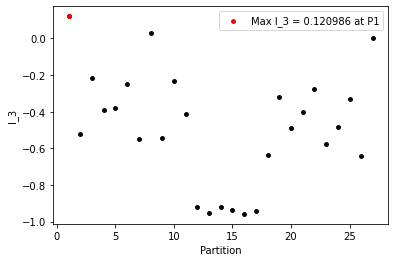


Case 8:

Given (gamma,lambda) = (0.99,0.0), the reconstruction error = 0.00869777 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0033 -0.0004  0.0097]
 [ 0.0068 -0.0008  0.0198]
 [ 0.012  -0.0015  0.035 ]
 [ 0.      0.     -0.    ]]

Matrix B:
[[ 1.1619  1.9316  2.4471  0.    ]
 [-0.1415 -0.2354 -0.2981  0.    ]
 [ 3.3734  5.6116  7.1076 -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0027 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9535  0.0057 -0.1352]
 [ 0.0057  0.9993  0.0165]
 [-0.1352  0.0165  0.6074]]

Minimum value of the cost function:
-6.475

Mutual information of the encoder:
0.28976791

Mutual information of the decoder:
0.29198441

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  0.

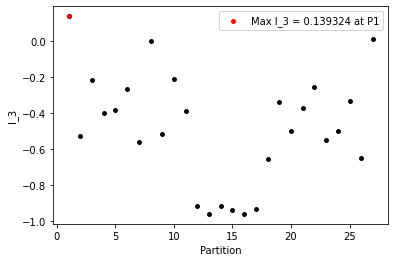


Case 9:

Given (gamma,lambda) = (0.99,0.01), the reconstruction error = 0.00865654 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0098  0.0015  0.0027]
 [ 0.02    0.0031  0.0055]
 [ 0.0353  0.0054  0.0097]
 [-0.     -0.      0.    ]]

Matrix B:
[[ 3.406   5.6644  7.182  -0.    ]
 [ 0.5245  0.872   1.1057 -0.    ]
 [ 0.9302  1.5478  1.9621  0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0027 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.5994 -0.0617 -0.1094]
 [-0.0617  0.9905 -0.0168]
 [-0.1094 -0.0168  0.9701]]

Minimum value of the cost function:
-6.4749

Mutual information of the encoder:
0.28989088

Mutual information of the decoder:
0.29209728

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008  0.    ]
 [ 0.0004  0.0008  0.0041 -

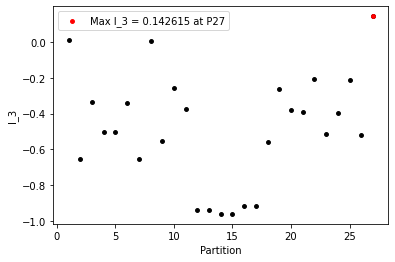


Case 10:

Given (gamma,lambda) = (0.99,0.02), the reconstruction error = 0.00861527 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0008  0.0063  0.0081]
 [ 0.0016  0.0128  0.0165]
 [ 0.0028  0.0227  0.0292]
 [-0.      0.     -0.    ]]

Matrix B:
[[ 0.2682  0.4464  0.5664 -0.    ]
 [ 2.1828  3.629   4.6061  0.    ]
 [ 2.8101  4.673   5.9308 -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0027 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9975 -0.0202 -0.0261]
 [-0.0202  0.8353 -0.212 ]
 [-0.0261 -0.212   0.727 ]]

Minimum value of the cost function:
-6.4748

Mutual information of the encoder:
0.2900142

Mutual information of the decoder:
0.29221048

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  

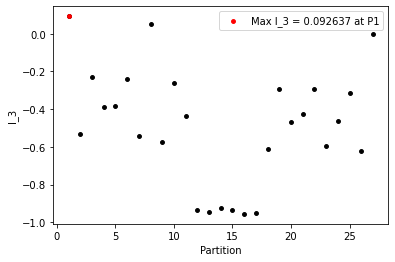


Case 11:

Given (gamma,lambda) = (1.0,-0.02), the reconstruction error = 0.00010988 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.      0.0066  0.0081]
 [ 0.0002  0.0067  0.0194]
 [ 0.0003  0.0174  0.0353]
 [-0.0004 -0.      0.    ]]

Matrix B:
[[-3.5200e-02  8.7600e-02  5.2800e-02 -2.2970e-01]
 [ 2.8444e+00  1.3003e+00  3.7167e+00 -7.5000e-03]
 [ 2.3907e+00  5.4312e+00  7.3170e+00  5.5000e-03]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0026 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9999 -0.0013 -0.0033]
 [-0.0013  0.9079 -0.1794]
 [-0.0033 -0.1794  0.6172]]

Minimum value of the cost function:
-6.5436

Mutual information of the encoder:
0.31923016

Mutual information of the decoder:
0.31925249

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.

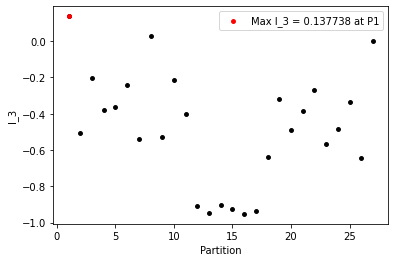


Case 12:

Given (gamma,lambda) = (1.0,-0.01), the reconstruction error = 5.948e-05 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.01    0.0003  0.0016]
 [ 0.0187  0.0007  0.0075]
 [ 0.0379  0.0012  0.0119]
 [ 0.     -0.0001  0.    ]]

Matrix B:
[[ 3.4540e+00  4.8550e+00  7.9615e+00  8.0000e-04]
 [ 6.7700e-02  1.9890e-01  2.5680e-01 -4.4800e-02]
 [ 1.1640e-01  2.3240e+00  2.4336e+00  2.2000e-03]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.5727 -0.0141 -0.1369]
 [-0.0141  0.9995 -0.0047]
 [-0.1369 -0.0047  0.9533]]

Minimum value of the cost function:
-6.5435

Mutual information of the encoder:
0.32048321

Mutual information of the decoder:
0.32049431

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0

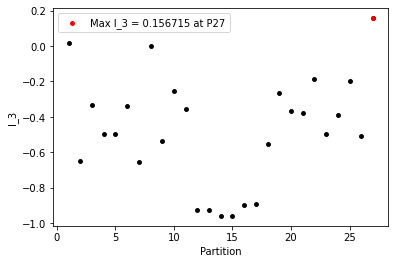


Case 13:

Given (gamma,lambda) = (1.0,0.0), the reconstruction error = 1e-06 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0071  0.0043  0.0059]
 [ 0.0152  0.0104  0.0083]
 [ 0.0293  0.0192  0.0189]
 [-0.      0.0001  0.    ]]

Matrix B:
[[ 2.2344  4.0959  6.1299 -0.031 ]
 [ 1.2359  2.8835  4.0033  0.0362]
 [ 2.2746  1.9102  4.0139  0.0113]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.7424 -0.1698 -0.1627]
 [-0.1698  0.8879 -0.1067]
 [-0.1627 -0.1067  0.8951]]

Minimum value of the cost function:
-6.5434

Mutual information of the encoder:
0.3208952

Mutual information of the decoder:
0.3208952

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  0.    ]


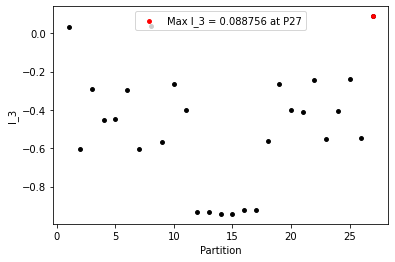


Case 14:

Given (gamma,lambda) = (1.0,0.01), the reconstruction error = 6.342e-05 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.004  -0.0006  0.0092]
 [ 0.008  -0.002   0.0182]
 [ 0.016  -0.0033  0.0365]
 [ 0.0034  0.0005 -0.0014]]

Matrix B:
[[ 1.301   2.112   3.3627  2.1098]
 [-0.1402 -0.5785 -0.6738  0.2998]
 [ 3.0139  4.7752  7.6858 -0.8968]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.917   0.015  -0.1702]
 [ 0.015   0.9964  0.0369]
 [-0.1702  0.0369  0.6033]]

Minimum value of the cost function:
-6.5434

Mutual information of the encoder:
0.32616288

Mutual information of the decoder:
0.32615157

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  0

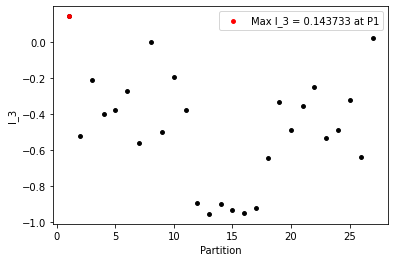


Case 15:

Given (gamma,lambda) = (1.0,0.02), the reconstruction error = 0.00011622 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.      0.0045  0.0089]
 [ 0.0006  0.0068  0.0189]
 [ 0.0004  0.018   0.0358]
 [-0.0001 -0.      0.    ]]

Matrix B:
[[-2.1100e-02  2.4500e-01  5.6400e-02 -3.2300e-02]
 [ 1.5296e+00  1.3866e+00  3.9654e+00 -5.2000e-03]
 [ 2.9013e+00  5.1682e+00  7.4372e+00  3.0000e-03]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9998 -0.0026 -0.0065]
 [-0.0026  0.9124 -0.1818]
 [-0.0065 -0.1818  0.61  ]]

Minimum value of the cost function:
-6.5433

Mutual information of the encoder:
0.32368312

Mutual information of the decoder:
0.3236602

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.00

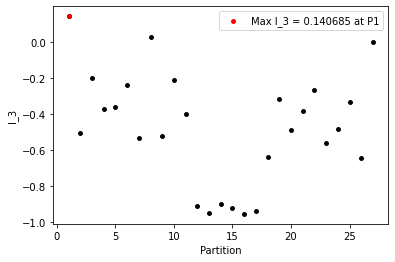


Case 16:

Given (gamma,lambda) = (1.01,-0.02), the reconstruction error = 0.00492992 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0059  0.0031  0.0011]
 [ 0.0117  0.0461 -0.0112]
 [ 0.0604  0.0067  0.0196]
 [-0.0129  0.012   0.0358]]

Matrix B:
[[ 0.     -0.0399 14.8177 -8.1284]
 [ 0.     20.0599 -2.2697  7.5397]
 [-0.     -6.7435  6.12   22.4766]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0.  0.]
 [-0.  0.  0.]]

Minimum value of the cost function:
-9.3142

Mutual information of the encoder:
70.03616001

Mutual information of the decoder:
70.01377372

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041 -0.   

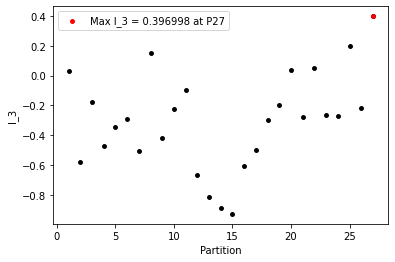


Case 17:

Given (gamma,lambda) = (1.01,-0.01), the reconstruction error = 0.00493041 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0012  0.0004  0.0066]
 [-0.0366 -0.0209  0.0247]
 [ 0.0091  0.0178  0.0607]
 [ 0.0226 -0.0323  0.0061]]

Matrix B:
[[ -0.     -17.1784   5.5769  14.1976]
 [ -0.     -10.9269   6.4965 -20.2943]
 [  0.       5.7775  13.7428   3.8321]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
264756.1228

Mutual information of the encoder:
70.34127285

Mutual information of the decoder:
70.3188864

Value of Sigma_X:
[[ 1.005  0.     0.   ]
 [ 0.     1.005 -0.   ]
 [ 0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008

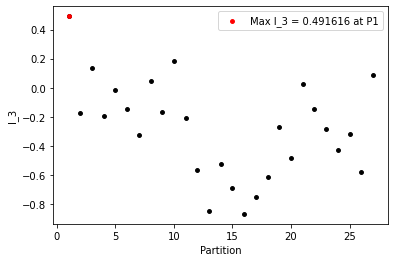


Case 18:

Given (gamma,lambda) = (1.01,0.0), the reconstruction error = 0.00493063 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0034  0.0041  0.0042]
 [ 0.0183  0.0442 -0.01  ]
 [ 0.0274  0.019   0.0545]
 [-0.0343  0.0168  0.0114]]

Matrix B:
[[  0.       5.7948   5.5902 -21.5702]
 [  0.      18.142    1.1068  10.5452]
 [ -0.      -9.2284  15.1557   7.1861]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-9.3194

Mutual information of the encoder:
70.55610693

Mutual information of the decoder:
70.53372028

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0

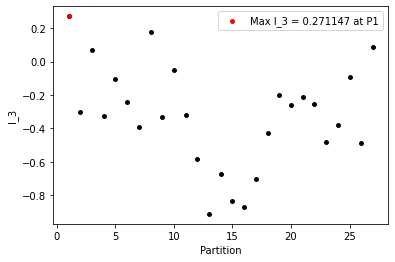


Case 19:

Given (gamma,lambda) = (1.01,0.01), the reconstruction error = 0.00493088 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0038  0.0017  0.0053]
 [-0.0113  0.0312  0.0359]
 [ 0.0509 -0.0005  0.0386]
 [ 0.0161  0.0299 -0.0209]]

Matrix B:
[[ -0.      -9.5046  14.327   10.1389]
 [  0.      14.017   -2.8454  18.7761]
 [  0.      12.691    6.9865 -13.1446]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
132373.4175

Mutual information of the encoder:
68.87373224

Mutual information of the decoder:
68.85134542

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008

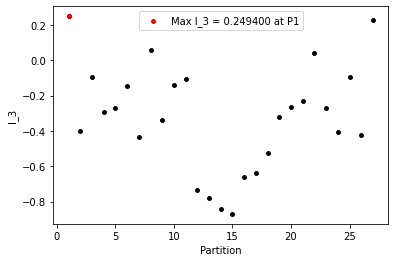


Case 20:

Given (gamma,lambda) = (1.01,0.02), the reconstruction error = 0.00493111 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0001  0.0052  0.0043]
 [ 0.0205  0.044  -0.0061]
 [-0.014   0.032   0.0535]
 [ 0.0336 -0.0133  0.0168]]

Matrix B:
[[ 0.     10.3856 -5.4642 21.1321]
 [ 0.     16.8914  4.5545 -8.3698]
 [-0.     -7.3956 14.5454 10.5592]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-9.3065

Mutual information of the encoder:
69.2710934

Mutual information of the decoder:
69.24870643

Value of Sigma_X:
[[ 1.005  0.     0.   ]
 [ 0.     1.005 -0.   ]
 [ 0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041 -0.    ]

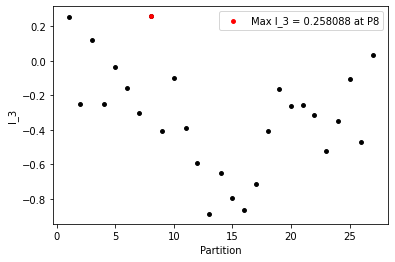


Case 21:

Given (gamma,lambda) = (1.02,-0.02), the reconstruction error = 0.00978105 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0046  0.      0.0049]
 [ 0.0373 -0.0309  0.0054]
 [ 0.03    0.0198  0.0526]
 [ 0.023   0.0238 -0.0221]]

Matrix B:
[[  0.      14.1481   4.6293  14.5104]
 [ -0.     -15.6589   7.9351  15.044 ]
 [ -0.      -2.1719  13.3815 -13.9408]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-11.5337

Mutual information of the encoder:
142.48821597

Mutual information of the decoder:
142.44366758

Value of Sigma_X:
[[ 1.0099 -0.     -0.    ]
 [-0.      1.0099 -0.    ]
 [-0.     -0.      1.0099]]

Value of Sigma_Y_hat:
[[0.0017 0.0002 0.0004 0.    ]
 [0.0002 0.0024 0.0008 0.    ]
 [0.0004 0.0008 

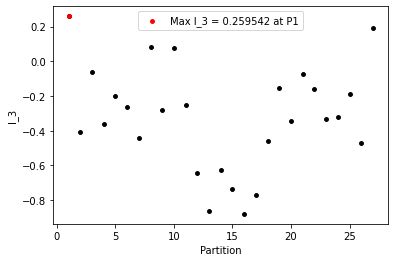


Case 22:

Given (gamma,lambda) = (1.02,-0.01), the reconstruction error = 0.00978122 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0034  0.0032  0.0048]
 [-0.0384  0.0295 -0.0055]
 [-0.0145  0.0189  0.0591]
 [ 0.0245  0.0311 -0.0039]]

Matrix B:
[[ -0.     -16.011   -0.4597  15.4527]
 [  0.      11.623    2.3843  19.6544]
 [ -0.      -7.6576  16.0489  -2.4773]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0.  0.]
 [ 0.  0. -0.]
 [ 0. -0.  0.]]

Minimum value of the cost function:
-11.542

Mutual information of the encoder:
142.90275925

Mutual information of the decoder:
142.85821039

Value of Sigma_X:
[[ 1.0099  0.      0.    ]
 [ 0.      1.0099 -0.    ]
 [ 0.     -0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004

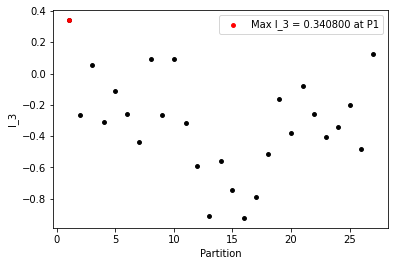


Case 23:

Given (gamma,lambda) = (1.02,0.0), the reconstruction error = 0.0094847 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0185 -0.0235  0.028 ]
 [ 0.0045  0.002   0.0118]
 [ 0.0313  0.0201  0.0517]
 [-0.0274  0.0283  0.0056]]

Matrix B:
[[-13.1139  -0.       9.0006 -17.3182]
 [-15.5118  -0.       6.4643  17.85  ]
 [ 13.9806   0.      11.3717   3.5603]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
3.15674710017772e+26

Mutual information of the encoder:
143.03663754

Mutual information of the decoder:
142.99208928

Value of Sigma_X:
[[ 1.0099 -0.     -0.    ]
 [-0.      1.0099 -0.    ]
 [-0.     -0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]

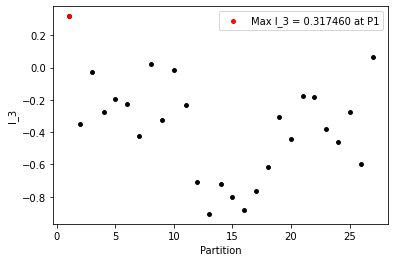


Case 24:

Given (gamma,lambda) = (1.02,0.01), the reconstruction error = 0.00948248 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0123  0.0154  0.036 ]
 [ 0.003   0.0124 -0.0008]
 [ 0.0111  0.06   -0.0185]
 [ 0.0376 -0.0097 -0.0087]]

Matrix B:
[[ 6.8253  0.      2.0698 23.742 ]
 [ 5.8072  0.     14.204  -6.0945]
 [22.9726  0.     -6.7879 -5.5133]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0.  0.]
 [-0.  0.  0.]]

Minimum value of the cost function:
-1.57837355008886e+26

Mutual information of the encoder:
143.07899391

Mutual information of the decoder:
143.03444631

Value of Sigma_X:
[[ 1.0099 -0.      0.    ]
 [-0.      1.0099  0.    ]
 [ 0.      0.      1.01  ]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.000

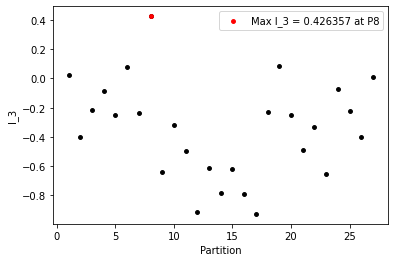


Case 25:

Given (gamma,lambda) = (1.02,0.02), the reconstruction error = 0.00978453 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.001   0.0005  0.0066]
 [ 0.0043 -0.0354  0.0332]
 [-0.014   0.028   0.0555]
 [ 0.0384  0.0093  0.005 ]]

Matrix B:
[[  0.       3.1509  -4.0662  24.2233]
 [ -0.     -18.4011  10.486    5.8745]
 [  0.      10.0776  11.7035   3.1527]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.  0.]
 [-0.  0. -0.]
 [ 0. -0.  0.]]

Minimum value of the cost function:
-1.57837355008886e+26

Mutual information of the encoder:
141.75456612

Mutual information of the decoder:
141.71001581

Value of Sigma_X:
[[ 1.01    0.      0.    ]
 [ 0.      1.0099 -0.    ]
 [ 0.     -0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008  0.  

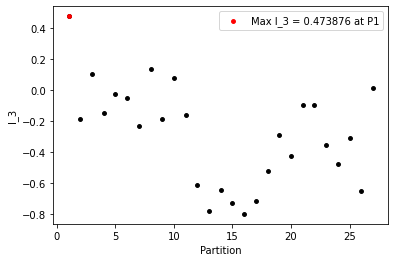

In [13]:
for case in range(num_cases):
    # Compute Sigma_Y given Sigma_V
    Sigma_V = generate_Sigma_V(case)
    
    Sigma_Y = eigenvectors @ Sigma_V @ eigenvectors.T + Sigma_Z_tilde
    print(colored('\nCovariance matrix of input data Y:', 'blue', attrs=['bold']))
    print(np.round(Sigma_Y, 4))
    is_positive_definite(Sigma_Y)
    
    # Constants
    MAX_SOLS = 5
    is_array = 1
    flag = 0
    case_num = 1

    # Initiate arrays
    min_recon_err_arr = []
    min_en_mi_arr = []
    min_de_mi_arr = []
    all_recon_mi_arr = []
    satisfied_recon_mi_arr = []
    satisfied_gamma_lambda_arr = []
    
    # Iteration step
    for i in range(0, len(gamma_arr)):
        gamma = gamma_arr[i]
        for j in range(0, len(lambda_arr)):
            lamda = lambda_arr[j]
        
            min_recon_err, min_en_mi, min_de_mi, min_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
        
            first_iter = 1
            for num_sols in range(0, MAX_SOLS):
                current_recon_err, current_en_mi, current_de_mi, current_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
    
                # Check for unique optimal solutions for each (gamma, lambda) pair
                if first_iter == 1:
                    if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - min_opt_sol[:2*n*m+n*n+m*m], 1e-6):
                        is_unique = 1
                        unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                    else:
                        is_unique = 0
                    first_iter = 0
                else:
                    if is_unique == 1:
                        if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - unique_opt_sol, 1e-6):
                            unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                        else:
                            is_unique = 0
    
                # Return the solution with smallest reconstruction error
                if current_recon_err < min_recon_err:
                    min_recon_err = current_recon_err
                    min_en_mi = current_en_mi
                    min_de_mi = current_de_mi
                    min_opt_sol = current_opt_sol
                
            min_recon_err_arr = np.concatenate((min_recon_err_arr, [min_recon_err]))
            min_en_mi_arr = np.concatenate((min_en_mi_arr, [min_en_mi]))
            min_de_mi_arr = np.concatenate((min_de_mi_arr, [min_de_mi]))
            all_recon_mi_arr = np.concatenate((all_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
            print(colored('\nCase {}:'.format(case_num), 'blue', attrs=['bold']))
            case_num += 1
        
            if min_recon_err > MAX_RECON_ERR:
                print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error = {} that EXCEEDS the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
            else:
                print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error = {} that SATISFIES the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
            
                satisfied_gamma_lambda_arr = np.concatenate((satisfied_gamma_lambda_arr, [gamma, lamda]))
                satisfied_recon_mi_arr = np.concatenate((satisfied_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
            if is_unique == 1:
                print(colored('The optimal solution is unique!\n', 'blue', attrs=['bold']))
            else:
                print(colored('The optimal solution is NOT unique!\n', 'red', attrs=['bold']))
        
            print_optimal_solution(min_opt_sol, m)
        
            # Compute mutual information I(V;X) and I_3
            B_opt = min_opt_sol[n*m:2*n*m].reshape((m, n))
            Sigma_W_opt = min_opt_sol[2*n*m+n*n:2*n*m+n*n+m*m].reshape((m, m))
        
            mutual_info_VX = mi_VX(B_opt, Sigma_W_opt)
            print('\nMutual information between generative variable and latent variable:')
            print(round(mutual_info_VX, 8))
        
            cov_XV = covariance_matrix_XV(B_opt)
            I3_arr = max_I3(cov_XV)
            plot_I3_vs_partition(I3_arr)